In [1]:
import uproot
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D  # For custom legend entries
from cycler import cycler

In [2]:
#Define global physics parameters
mu_n = -1.9130427
mu_p = 2.792847351
mu_n_simc = -1.913 #truncated precision as it appears in simc code (physics_proton.f)
mu_p_simc = 2.793 #truncated precision as it appears in simc code (physics_proton.f)
M_p = 0.938272
M_n = 0.939565
M_pi = 0.13957

In [3]:
#Define global model parameters
rior_err_fac = 0.097
arr_err_fac = 0.005
ye_t0 = -0.7
GD_range_fac = 0.71

ye_tcut = 4*pow(M_pi,2)

In [4]:
#Define parameters for Riordan, Kelly, Ye, and Arrington07
#In same order, sources:
#simc code
#Kelly Parameterization (https://journals.aps.org/prc/abstract/10.1103/PhysRevC.70.068202)
#Ye, Arrington, Hill, & Lee Parameterization, 2018 (https://doi.org/10.1016/j.physletb.2017.11.023)
#Arrington07 Global Analysis of proton elastic form factor data with tpe corrections (https://journals.aps.org/prc/pdf/10.1103/PhysRevC.76.035205)

# Define S Riordan parameters for GEn
riordan_params = {
    'a_coeffs': [0, 1.52, 2.629, 3.055],
    'b_coeffs': [1, 5.222, 0.04, 11.438],
    'a_err': [0, 0.14744, 0.255013, 0.296335],
    'b_err': [0, 0.506534, 0.00388, 1.109486]
}

# Define JJ Kelly parameters for GEn
kelly_GEn_params = {
    'a_coeffs': [0, 1.7, 0, 0],
    'a_err': [0, 0.04, 0, 0],
    'b_coeffs': [1, 3.3, 0, 0],
    'b_err': [0, 0.32, 0, 0],
}

# Define JJ Kelly parameters for GEp
kelly_GEp_params = {
    'a_coeffs': [1, -0.24, 0, 0],
    'a_err': [0, 0.12, 0, 0],
    'b_coeffs': [1, 10.98, 12.82, 21.97],
    'b_err': [0, 0.19, 1.1, 6.8],
}

# Define JJ Kelly parameters for GMn/mu_n
kelly_GMn_mun_params = {
    'a_coeffs': [1, 2.33, 0, 0],
    'a_err': [0, 1.4, 0, 0],
    'b_coeffs': [1, 14.72, 24.2, 84.1],
    'b_err': [0, 1.7, 9.8, 41],
}

# Define JJ Kelly parameters for GMp/mu_p
kelly_GMp_mup_params = {
    'a_coeffs': [1, 0.12, 0, 0],
    'a_err': [0, 0.04, 0, 0],
    'b_coeffs': [1, 10.97, 18.86, 6.55],
    'b_err': [0, 0.11, 0.28, 1.2],
}

# Define J Arrington 7 parameters for GEp
arrington07_GEp_params = {
    'a_coeffs': [1, 3.439, -1.602, 0.068],
    'b_coeffs': [1, 15.055, 48.061, 99.304, 0.012, 8.65]
}

# Define J Arrington 7 parameters for GMp
arrington07_GMp_mup_params = {
    'a_coeffs': [1, -1.465, 1.26, 0.262],
    'b_coeffs': [1, 9.627, 0, 0, 11.179, 13.245]
}

# Define J Arrington 7 parameters for GEp
arrington07uncorr_GEp_params = {
    'a_coeffs': [1, -1.651, 1.287, -0.185],
    'b_coeffs': [1, 9.531, 0.591, 0, 0, 4.994]
}

# Define J Arrington 7 parameters for GMp
arrington07uncorr_GMp_mup_params = {
    'a_coeffs': [1, -2.151, 4.261, 0.159],
    'b_coeffs': [1, 8.647, 0.001, 5.245, 82.817, 14.191]
}

# Define the Ye parameters for GEn
ye_GEn_params = {
    'a_coeffs': [0.048919981, -0.064525054, -0.240825897, 0.392108745, 0.300445259, -0.661888687, -0.17563977, 0.624691724, -0.077684299, -0.236003975, 0.090401973, 0, 0],
    'a_err': [-2.07194073, 1.13809127, 1.01431277, -0.31330138, -0.273293676, 0.257350595, -0.206042113, -0.168497322, 0.137784515, 0.075759196, -0.02675113, -0.017525731, 0.000703582, 0.001479621, 0.000197375]
}

# Define the Ye parameters for GMn/mu_n
ye_GMn_mun_params = {
    'a_coeffs': [0.257758327, -1.079540642, 1.182183812, 0.711015086, -1.348080937, -1.662444025, 2.624354426, 1.751234495, -4.922300879, 3.197892727, -0.71207239, 0, 0],
    'a_err': [-2.06920873, 0.06431564, -0.355593786, 0.41489766, 1.95746824, 0.2705257, -1.52685784, -0.443527359, 0.516884065, 0.207915837, -0.07486657, -0.042541143, 0.00154965, 0.003253223, 0.00042082]
}

# Define the Ye parameters for GEp
ye_GEp_params = {
    'a_coeffs': [0.239163298, -1.109858574, 1.444380813, 0.479569466, -2.286894742, 1.126632985, 1.250619844, -3.631020472, 4.082217024, 0.504097346, -5.085120461, 3.967742544, -0.981529071],
    'a_err': [-1.97750308, -0.446566998, 0.294508717, 1.54467525, 0.905268347, -0.600008111, -1.10732394, -0.098598272, 0.463035988, 0.137729116, -0.078299163, -0.036305693, 0.002642193, 0.003132614, 0.000389594]
}

# Define the Ye parameters for GMp/mu_p
ye_GMp_mup_params = {
    'a_coeffs': [0.264142994, -1.095306122, 1.218553782, 0.661136494, -1.405678925, -1.356418439, 1.447029155, 4.235669736, -5.334045653, -2.916300521, 8.707403068, -5.706999944, 1.280814376],
    'a_err': [-1.76549673, 0.167218457, -1.20542733, -0.472244127, 1.41548871, 0.661320779, -0.816422909, -0.373804477, 0.262223992, 0.128886639, -0.039090151, -0.024499518, 0.00083427, 0.001882264, 0.000243073]
}

# Define the Alberico paremeters for TPE corrected GEn
alberico_GEn_params = {
    'a_coeffs': [-0.10],
    'a_err': [0.02],
    'b_coeffs': [2.83, 0.43],
    'b_err': [0.37, 0.11]
}

In [5]:
# World Data

#GMn world data + this work at the beginning
GMn_data_short = [
  #["This Work: SBS-9", 4.45, 0.9357, 0.0210], 
  #["This Work: SBS-8", 4.31, 0.9694, 0.0344], 
  ["This Work: SBS-4 30% Field", 2.994, 0.960, 0.023],
  ["This Work: SBS-4 50% Field", 2.982, 0.967, 0.024],
  ["This Work: SBS-8 50% Field", 4.398, 0.949, 0.033],
  ["This Work: SBS-8 70% Field", 4.41, 0.943, 0.032],
  ["This Work: SBS-8 100% Field", 4.398, 0.938, 0.033],
  ["This Work: SBS-9 70% Field", 4.47, 0.952, 0.029],
  ["Xu", 0.3, 0.972, 0.0580345],
  ["Xu", 0.4, 0.984, 0.0410974],
  ["Xu", 0.5, 0.984, 0.0379605],
  ["Xu", 0.6, 1.01, 0.0330757],
  ["Kubon 2001", 0.071, 0.99, 0.013],
  ["Kubon 2001", 0.125, 0.967, 0.013],
  ["Kubon 2001", 0.359, 0.989, 0.014],
  ["Kubon 2001", 0.894, 1.062, 0.017],
  ["Xu 2000", 0.1, 0.962, 0.0172047],
  ["Xu 2000", 0.2, 0.959, 0.0164012],
  ["Anklin 1998", 0.235, 0.962, 0.009],
  ["Anklin 1998", 0.504, 1.032, 0.012],
  ["Anklin 1998", 0.652, 1.037, 0.012],
  ["Anklin 1998", 0.784, 1.043, 0.012],
  ["H Gao 1998", 0.19, 0.931, 0.0572451],
  ["EEW Bruins 1995", 0.125, 1.02, 0.0234307],
  ["EEW Bruins 1995", 0.255, 1.076, 0.0230217],
  ["EEW Bruins 1995", 0.417, 1.135, 0.0371214],
  ["EEW Bruins 1995", 0.605, 1.104, 0.0349285],
  ["A Lung 1993", 1.75, 1.052, 0.0519711],
  ["A Lung 1993", 2.5, 1.014, 0.0443847],
  ["A Lung 1993", 3.25, 0.967, 0.0605392],
  ["A Lung 1993", 4, 0.923, 0.0808022],
  ["P Markowitz 1993", 0.109, 1.136, 0.0361248],
  ["P Markowitz 1993", 0.176, 1.039, 0.0316386],
  ["P Markowitz 1993", 0.255, 1.028, 0.0388201],
  ["RG Arnold 1988", 1, 0.943, 0.086],
  ["RG Arnold 1988", 1.31, 0.99, 0.1],
  ["RG Arnold 1988", 1.58, 0.9, 0.143],
  ["RG Arnold 1988", 1.74, 1.05, 0.076],
  ["AS Esaulov 1987", 0.482, 0.941, 0.048],
  ["AS Esaulov 1987", 0.545, 1.037, 0.043],
  ["AS Esaulov 1987", 0.608, 1.285, 0.035],
  ["AS Esaulov 1987", 0.646, 1.156, 0.035],
  ["AS Esaulov 1987", 0.692, 1.121, 0.038],
  ["AS Esaulov 1987", 0.832, 1.079, 0.044],
  ["KM Hanson 1973", 0.272, 0.874, 0.057],
  ["KM Hanson 1973", 0.389, 0.989, 0.025],
  ["KM Hanson 1973", 0.584, 0.94, 0.058],
  ["KM Hanson 1973", 0.779, 0.787, 0.058],
  ["KM Hanson 1973", 1.168, 0.954, 0.043],
  ["KM Hanson 1973", 1.752, 0.999, 0.075],
  ["W Bartel 1969-72", 1, 0.975, 0.055],
  ["W Bartel 1969-72", 1.53, 1.055, 0.055],
  ["W Bartel 1969-72", 0.39, 0.99, 0.1],
  ["W Bartel 1969-72", 0.565, 1.02, 0.08],
  ["P Stein 1966", 0.389, 1.03, 0.08],
  ["P Stein 1966", 0.564, 1.08, 0.071],
  ["Hughes 1965", 0.039, 1.51, 0.323],
  ["Hughes 1965", 0.058, 1.09, 0.057],
  ["Hughes 1965", 0.097, 1.22, 0.036],
  ["Hughes 1965", 0.18, 1.1, 0.038],
  ["Hughes 1965", 0.29, 0.984, 0.026],
  ["Hughes 1965", 0.389, 1.04, 0.026],
  ["Hughes 1965", 0.486, 1.08, 0.045],
  ["Hughes 1965", 0.584, 1.1, 0.05],
  ["Hughes 1965", 0.778, 1.09, 0.14],
  ["Hughes 1965", 0.973, 1.26, 0.105],
  ["Hughes 1965", 1.17, 1.09, 0.2],
]

#Ye GMn/GD at SBS-4: 0.9999452081477678
#Ye GMn/GD at SBS-8: 0.9351323404783721
#Ye GMn/GD at SBS-7: 0.7251009128326998
#Ye GMn/GD at SBS-11: 0.6206290759770225
#Ye GMn/GD at SBS-14: 0.8118234225994339

GMn_data_proj = [
  ["Projected: SBS-4", 3.0, 0.9999, 0.0], 
  ["Projected: SBS-8/9", 4.5, 0.9351, 0.0], 
  ["Projected: SBS-7", 10, 0.7251, 0.0],
  ["Projected: SBS-11", 13.6, 0.6206, 0.0],
  ["Projected: SBS-14", 7.5, 0.8118, 0.0],
]

#["This Work: SBS-9", 4.45, 0.9357, 0.0210], 
#["This Work: SBS-8", 4.31, 0.9694, 0.0344], 
#["This Work: SBS-4 50% Field", 2.98, 0.9740, 0.0230],
#["This Work: SBS-4 30% Field", 2.96, 0.9498, 0.0159], 

#GMn world data, no detail (from 50 yrs QCD)
GMn_data_nodetail_wextr = [
  ["This Work: SBS-4 30% Field", 2.994, 0.960, 0.023],
  ["This Work: SBS-4 50% Field", 2.982, 0.967, 0.024],
  ["This Work: SBS-8 50% Field", 4.398, 0.949, 0.033],
  ["This Work: SBS-8 70% Field", 4.41, 0.943, 0.032],
  ["This Work: SBS-8 100% Field", 4.398, 0.938, 0.033],
  ["This Work: SBS-9 70% Field", 4.47, 0.952, 0.029],
  ["world data", 0.111211, 0.957, 0.016],
  ["world data", 0.235, 0.962, 0.009],
  ["world data", 0.504, 1.032, 0.012],
  ["world data", 0.652, 1.037, 0.012],
  ["world data", 0.784, 1.043, 0.012],
  ["world data", 0.9848, 0.9953, 0.0224722],
  ["world data", 1.1364, 1.0073, 0.0262185],
  ["world data", 1.2879, 1.0319, 0.0231482],
  ["world data", 1.4394, 1.0228, 0.0210924],
  ["world data", 1.5909, 1.0127, 0.0200811],
  ["world data", 1.7424, 1.0136, 0.0201137],
  ["world data", 1.8939, 1.0167, 0.0200489],
  ["world data", 2.0455, 1, 0.0219829],
  ["world data", 2.197, 0.9919, 0.0221678],
  ["world data", 2.3485, 1.0016, 0.0226177],
  ["world data", 2.5, 1.0212, 0.0250402],
  ["world data", 2.6515, 1.0344, 0.024508],
  ["world data", 2.803, 1.0012, 0.0238472],
  ["world data", 2.9546, 0.9954, 0.024337],
  ["world data", 3.1061, 1.0019, 0.0253503],
  ["world data", 3.2576, 0.9779, 0.025242],
  ["world data", 3.4091, 0.9967, 0.0263788],
  ["world data", 3.5606, 0.9918, 0.0257402],
  ["world data", 3.7121, 0.9742, 0.027131],
  ["world data", 3.8636, 0.9791, 0.0292062],
  ["world data", 4.0152, 1.0285, 0.0309684],
  ["world data", 4.1667, 0.9193, 0.0314841],
  ["world data", 4.3182, 0.9079, 0.0339612],
  ["world data", 4.4697, 0.9903, 0.0421777],
  ["world data", 4.6212, 1.1074, 0.099886],
  ["world data", 4.7727, 1.0921, 0.130951],
  ["world data", 0.125, 1.02, 0.0234307],
  ["world data", 0.255, 1.076, 0.0230217],
  ["world data", 0.417, 1.135, 0.0371214],
  ["world data", 0.605, 1.104, 0.0349285],
  ["world data", 0.19, 0.998999, 0.0585586],
  ["world data", 0.1, 0.9481, 0.0265468],
  ["world data", 0.193, 0.9511, 0.0266308],
  ["world data", 0.3, 0.9577, 0.0555466],
  ["world data", 0.4, 0.9694, 0.0310208],
  ["world data", 0.5, 0.9689, 0.0271292],
  ["world data", 0.6, 0.9939, 0.0288231],
  ["world data", 0.071, 0.99, 0.013],
  ["world data", 0.125, 0.967, 0.013],
  ["world data", 0.359, 0.989, 0.014],
  ["world data", 0.894, 1.062, 0.017],
  ["world data", 1.75, 1.052, 0.026],
  ["world data", 2.5, 1.014, 0.017],
  ["world data", 3.25, 0.967, 0.031],
  ["world data", 4, 0.923, 0.048],
  ["world data", 0.109, 1.136, 0.022],
  ["world data", 0.176, 1.039, 0.01],
  ["world data", 0.255, 1.028, 0.025],
  ["world data", 2.5, 0.983007, 0.0427394],
  ["world data", 4, 0.943158, 0.0460077],
  ["world data", 6, 0.910413, 0.0466878],
  ["world data", 8, 0.708007, 0.118001],
  ["world data", 10, 0.630396, 0.154625],
  ["world data", 0.1, 0.962, 0.0172047],
  ["world data", 0.2, 0.959, 0.0164012],
  ["world data", 0.3, 0.972, 0.0212603],
  ["world data", 0.4, 0.984, 0.0300832],
  ["world data", 0.5, 0.984, 0.025632],
  ["world data", 0.6, 1.01, 0.0299666],
]

#GMn world data, no detail (from 50 yrs QCD)
GMn_data_nodetail = [
  ["projected: SBS-4", 3.0, 0.9999, 0.0], 
  ["projected: SBS-8/9", 4.5, 0.9351, 0.0], 
  ["projected: SBS-7", 10, 0.7251, 0.0],
  ["projected: SBS-11", 13.6, 0.6206, 0.0],
  ["projected: SBS-14", 7.5, 0.8118, 0.0],
  ["world data", 0.111211, 0.957, 0.016],
  ["world data", 0.235, 0.962, 0.009],
  ["world data", 0.504, 1.032, 0.012],
  ["world data", 0.652, 1.037, 0.012],
  ["world data", 0.784, 1.043, 0.012],
  ["world data", 0.9848, 0.9953, 0.0224722],
  ["world data", 1.1364, 1.0073, 0.0262185],
  ["world data", 1.2879, 1.0319, 0.0231482],
  ["world data", 1.4394, 1.0228, 0.0210924],
  ["world data", 1.5909, 1.0127, 0.0200811],
  ["world data", 1.7424, 1.0136, 0.0201137],
  ["world data", 1.8939, 1.0167, 0.0200489],
  ["world data", 2.0455, 1, 0.0219829],
  ["world data", 2.197, 0.9919, 0.0221678],
  ["world data", 2.3485, 1.0016, 0.0226177],
  ["world data", 2.5, 1.0212, 0.0250402],
  ["world data", 2.6515, 1.0344, 0.024508],
  ["world data", 2.803, 1.0012, 0.0238472],
  ["world data", 2.9546, 0.9954, 0.024337],
  ["world data", 3.1061, 1.0019, 0.0253503],
  ["world data", 3.2576, 0.9779, 0.025242],
  ["world data", 3.4091, 0.9967, 0.0263788],
  ["world data", 3.5606, 0.9918, 0.0257402],
  ["world data", 3.7121, 0.9742, 0.027131],
  ["world data", 3.8636, 0.9791, 0.0292062],
  ["world data", 4.0152, 1.0285, 0.0309684],
  ["world data", 4.1667, 0.9193, 0.0314841],
  ["world data", 4.3182, 0.9079, 0.0339612],
  ["world data", 4.4697, 0.9903, 0.0421777],
  ["world data", 4.6212, 1.1074, 0.099886],
  ["world data", 4.7727, 1.0921, 0.130951],
  ["world data", 0.125, 1.02, 0.0234307],
  ["world data", 0.255, 1.076, 0.0230217],
  ["world data", 0.417, 1.135, 0.0371214],
  ["world data", 0.605, 1.104, 0.0349285],
  ["world data", 0.19, 0.998999, 0.0585586],
  ["world data", 0.1, 0.9481, 0.0265468],
  ["world data", 0.193, 0.9511, 0.0266308],
  ["world data", 0.3, 0.9577, 0.0555466],
  ["world data", 0.4, 0.9694, 0.0310208],
  ["world data", 0.5, 0.9689, 0.0271292],
  ["world data", 0.6, 0.9939, 0.0288231],
  ["world data", 0.071, 0.99, 0.013],
  ["world data", 0.125, 0.967, 0.013],
  ["world data", 0.359, 0.989, 0.014],
  ["world data", 0.894, 1.062, 0.017],
  ["world data", 1.75, 1.052, 0.026],
  ["world data", 2.5, 1.014, 0.017],
  ["world data", 3.25, 0.967, 0.031],
  ["world data", 4, 0.923, 0.048],
  ["world data", 0.109, 1.136, 0.022],
  ["world data", 0.176, 1.039, 0.01],
  ["world data", 0.255, 1.028, 0.025],
  ["world data", 2.5, 0.983007, 0.0427394],
  ["world data", 4, 0.943158, 0.0460077],
  ["world data", 6, 0.910413, 0.0466878],
  ["world data", 8, 0.708007, 0.118001],
  ["world data", 10, 0.630396, 0.154625],
  ["world data", 0.1, 0.962, 0.0172047],
  ["world data", 0.2, 0.959, 0.0164012],
  ["world data", 0.3, 0.972, 0.0212603],
  ["world data", 0.4, 0.984, 0.0300832],
  ["world data", 0.5, 0.984, 0.025632],
  ["world data", 0.6, 1.01, 0.0299666],
]

#GMn world data + this work at the beginning
GMn_data = [
  #["This Work: SBS-8", 4.501, 0.93508835, 0.05],
  #["This Work: SBS-9", 4.5038, 0.934965187, 0.05],  
  #["This Work: SBS-4", 3.0335, 0.958251, 0.04],
  ["This Work: SBS-4 30% Field", 2.994, 0.960, 0.023],
  ["This Work: SBS-4 50% Field", 2.982, 0.967, 0.024],
  ["This Work: SBS-8 50% Field", 4.398, 0.949, 0.033],
  ["This Work: SBS-8 70% Field", 4.41, 0.943, 0.032],
  ["This Work: SBS-8 100% Field", 4.398, 0.938, 0.033],
  ["This Work: SBS-9 70% Field", 4.47, 0.952, 0.029],
  ["Xu", 0.3, 0.972, 0.0580345],
  ["Xu", 0.4, 0.984, 0.0410974],
  ["Xu", 0.5, 0.984, 0.0379605],
  ["Xu", 0.6, 1.01, 0.0330757],
  ["Kubon 2001", 0.071, 0.99, 0.013],
  ["Kubon 2001", 0.125, 0.967, 0.013],
  ["Kubon 2001", 0.359, 0.989, 0.014],
  ["Kubon 2001", 0.894, 1.062, 0.017],
  ["Xu 2000", 0.1, 0.962, 0.0172047],
  ["Xu 2000", 0.2, 0.959, 0.0164012],
  ["Anklin 1998", 0.235, 0.962, 0.009],
  ["Anklin 1998", 0.504, 1.032, 0.012],
  ["Anklin 1998", 0.652, 1.037, 0.012],
  ["Anklin 1998", 0.784, 1.043, 0.012],
  ["EEW Bruins 1995", 0.125, 1.02, 0.0234307],
  ["EEW Bruins 1995", 0.255, 1.076, 0.0230217],
  ["EEW Bruins 1995", 0.417, 1.135, 0.0371214],
  ["EEW Bruins 1995", 0.605, 1.104, 0.0349285],
  ["Anklin 1994", 1.69, 0.111, 0.957134],
  ["H Gao 1998", 0.19, 0.931, 0.0572451],
  ["A Lung 1993", 1.75, 1.052, 0.0519711],
  ["A Lung 1993", 2.5, 1.014, 0.0443847],
  ["A Lung 1993", 3.25, 0.967, 0.0605392],
  ["A Lung 1993", 4, 0.923, 0.0808022],
  ["P Markowitz 1993", 0.109, 1.136, 0.0361248],
  ["P Markowitz 1993", 0.176, 1.039, 0.0316386],
  ["P Markowitz 1993", 0.255, 1.028, 0.0388201],
  ["RG Arnold 1988", 1, 0.943, 0.086],
  ["RG Arnold 1988", 1.31, 0.99, 0.1],
  ["RG Arnold 1988", 1.58, 0.9, 0.143],
  ["RG Arnold 1988", 1.74, 1.05, 0.076],
  ["AS Esaulov 1987", 0.482, 0.941, 0.048],
  ["AS Esaulov 1987", 0.545, 1.037, 0.043],
  ["AS Esaulov 1987", 0.608, 1.285, 0.035],
  ["AS Esaulov 1987", 0.646, 1.156, 0.035],
  ["AS Esaulov 1987", 0.692, 1.121, 0.038],
  ["AS Esaulov 1987", 0.832, 1.079, 0.044],
  ["KM Hanson 1973", 0.272, 0.874, 0.057],
  ["KM Hanson 1973", 0.389, 0.989, 0.025],
  ["KM Hanson 1973", 0.584, 0.94, 0.058],
  ["KM Hanson 1973", 0.779, 0.787, 0.058],
  ["KM Hanson 1973", 1.168, 0.954, 0.043],
  ["KM Hanson 1973", 1.752, 0.999, 0.075],
  ["W Bartel 1972", 1, 0.975, 0.055],
  ["W Bartel 1972", 1.53, 1.055, 0.055],
  ["W Bartel 1969", 0.39, 0.99, 0.1],
  ["W Bartel 1969", 0.565, 1.02, 0.08],
  ["RJ Budnitz 1968", 0.292, 0.964, 0.0505371],
  ["RJ Budnitz 1968", 0.3894, 0.812, 0.0474236],
  ["RJ Budnitz 1968", 0.584, 0.637, 0.0346699],
  ["RJ Budnitz 1968", 0.7784, 0.435, 0.0518941],
  ["RJ Budnitz 1968", 1.168, 0.267, 0.0233452],
  ["RJ Budnitz 1968", 1.752, 0.22, 0.0296142],
  ["RJ Budnitz 1968", 2.752, 0.093, 0.111041],
  ["RJ Budnitz 1968", 3.894, 0.06, 0.0680294],
  ["RJ Budnitz 1968", 4.478, 0.056, 0.0660303],
  ["RJ Budnitz 1968", 6.814, 0.016, 0.0320156],
  ["P Stein 1966", 0.389, 1.03, 0.08],
  ["P Stein 1966", 0.564, 1.08, 0.071],
  ["Hughes 1965", 0.039, 1.51, 0.323],
  ["Hughes 1965", 0.058, 1.09, 0.057],
  ["Hughes 1965", 0.097, 1.22, 0.036],
  ["Hughes 1965", 0.18, 1.1, 0.038],
  ["Hughes 1965", 0.29, 0.984, 0.026],
  ["Hughes 1965", 0.389, 1.04, 0.026],
  ["Hughes 1965", 0.486, 1.08, 0.045],
  ["Hughes 1965", 0.584, 1.1, 0.05],
  ["Hughes 1965", 0.778, 1.09, 0.14],
  ["Hughes 1965", 0.973, 1.26, 0.105],
  ["Hughes 1965", 1.17, 1.09, 0.2],
]

#GMp Eric Christy GMp Supplemental
GMp_data = [
    ["Andivahis_1", 1.75, 1.05533, 0.00681],
    ["Andivahis_1", 1.75, 1.05884, 0.0067],
    ["Andivahis_1", 1.7499, 1.05323, 0.00753],
    ["Andivahis_1", 2.5, 1.06098, 0.00787],
    ["Andivahis_1", 2.5, 1.05546, 0.00756],
    ["Andivahis_1", 2.5, 1.05217, 0.00764],
    ["Andivahis_1", 2.5, 1.05541, 0.00667],
    ["Andivahis_1", 2.4937, 1.05131, 0.00709],
    ["Andivahis_1", 2.5001, 1.05002, 0.00739],
    ["Andivahis_1", 3.25, 1.05034, 0.00856],
    ["Andivahis_1", 3.2501, 1.05319, 0.00748],
    ["Andivahis_1", 3.25, 1.05416, 0.00757],
    ["Andivahis_1", 3.25, 1.04878, 0.00684],
    ["Andivahis_1", 4, 1.04206, 0.00935],
    ["Andivahis_1", 4.0001, 1.04074, 0.00875],
    ["Andivahis_1", 4.0001, 1.048, 0.00891],
    ["Andivahis_1", 4, 1.03358, 0.00769],
    ["Andivahis_1", 3.9999, 1.04494, 0.0078],
    ["Andivahis_1", 5.0001, 1.0436, 0.0121],
    ["Andivahis_1", 5.0001, 1.02264, 0.00947],
    ["Andivahis_1", 5, 1.02239, 0.00815],
    ["Andivahis_1", 5.0001, 1.02522, 0.00866],
    ["Andivahis_1", 5.9998, 1.00079, 0.00944],
    ["Andivahis_1", 7.0001, 1.00437, 0.0137],
    ["Andivahis_2", 1.75, 1.05697, 0.00702],
    ["Andivahis_2", 2.5, 1.05991, 0.00711],
    ["Andivahis_2", 3.25, 1.05229, 0.00774],
    ["Andivahis_2", 4, 1.04081, 0.00803],
    ["Andivahis_2", 5.0001, 1.02071, 0.00821],
    ["Andivahis_2", 6.0001, 0.99864, 0.00915],
    ["Andivahis_2", 7.0001, 0.97704, 0.0128],
    ["Andivahis_2", 8.8301, 0.92839, 0.0191],
    ["Christy", 0.6203, 0.99995, 0.00554],
    ["Christy", 0.8175, 1.01693, 0.00554],
    ["Christy", 0.8999, 1.02768, 0.00614],
    ["Christy", 0.6185, 1.00644, 0.00642],
    ["Christy", 1.1121, 1.03696, 0.00635],
    ["Christy", 1.6353, 1.05633, 0.00627],
    ["Christy", 2.2471, 1.05126, 0.00602],
    ["Christy", 2.7806, 1.05821, 0.00641],
    ["Christy", 0.4243, 0.98591, 0.00629],
    ["Christy", 0.6635, 1.01328, 0.00686],
    ["Christy", 0.9313, 1.02163, 0.00664],
    ["Christy", 2.0354, 1.0548, 0.00621],
    ["Christy", 2.6203, 1.05509, 0.00588],
    ["Christy", 3.1682, 1.05249, 0.00599],
    ["Christy", 3.7257, 1.0453, 0.00621],
    ["Christy", 4.2325, 1.02683, 0.00768],
    ["Christy", 3.7986, 1.05205, 0.00644],
    ["Christy", 4.4008, 1.04463, 0.011],
    ["Christy", 4.7964, 1.03093, 0.0109],
    ["Christy", 5.2619, 1.02326, 0.0093],
    ["Christy", 1.3435, 1.05272, 0.00785],
    ["Christy", 2.2886, 1.04759, 0.00739],
    ["Christy", 2.7829, 1.055, 0.00708],
    ["Christy", 3.2689, 1.05018, 0.00688],
    ["Christy", 3.7392, 1.04222, 0.0079],
    ["Christy", 4.1874, 1.04831, 0.00721],
    ["Christy", 5.0036, 1.03172, 0.00801],
    ["Christy", 5.3703, 1.03383, 0.00996],
    ["GMp12L", 1.5771, 1.0541, 0.00656],
    ["GMp12L", 4.5434, 1.03063, 0.00877],
    ["GMp12L", 5.9471, 1.0046, 0.00834],
    ["GMp12L", 6.9929, 0.97829, 0.00826],
    ["GMp12L", 7.9918, 0.94787, 0.00837],
    ["GMp12L", 9.0021, 0.93424, 0.00937],
    ["GMp12L", 9.8073, 0.9161, 0.00923],
    ["GMp12L", 11.187, 0.88919, 0.00909],
    ["GMp12R", 1.8585, 1.05635, 0.0119],
    ["GMp12R", 9.0526, 0.92854, 0.0117],
    ["GMp12R", 12.069, 0.86869, 0.0115],
    ["GMp12R", 12.568, 0.85322, 0.0149],
    ["GMp12R", 15.755, 0.83191, 0.0132],
    ["Kirk", 0.999, 1.02534, 0.0109],
    ["Kirk", 1.4987, 1.0594, 0.011],
    ["Kirk", 1.9983, 1.06655, 0.0123],
    ["Kirk", 2.5012, 1.0535, 0.00994],
    ["Kirk", 3.7592, 1.05, 0.0117],
    ["Kirk", 5.0752, 1.01755, 0.0122],
    ["Kirk", 6.275, 0.97662, 0.0231],
    ["Kirk", 7.5038, 0.95539, 0.0163],
    ["Kirk", 8.7479, 0.88375, 0.0271],
    ["Kirk", 9.9841, 0.91703, 0.0199],
    ["Kirk", 12.507, 0.8471, 0.0322],
    ["Kirk", 15.098, 0.82534, 0.044],
    ["Kirk", 19.991, 0.77412, 0.0765],
    ["Kirk", 25.021, 1.00726, 0.221],
    ["Rock", 2.4946, 1.05996, 0.0058],
    ["Rock", 3.9896, 1.03302, 0.00668],
    ["Rock", 5.9961, 0.99879, 0.00866],
    ["Rock", 7.9883, 0.95647, 0.0131],
    ["Rock", 10.004, 0.92042, 0.0186],
    ["Sill", 2.8617, 1.04938, 0.0213],
    ["Sill", 3.6214, 1.04878, 0.0231],
    ["Sill", 5.0266, 1.02966, 0.0202],
    ["Sill", 4.9906, 1.03324, 0.0217],
    ["Sill", 5.0166, 1.02062, 0.0204],
    ["Sill", 7.3004, 0.9669, 0.0215],
    ["Sill", 9.624, 0.90274, 0.0216],
    ["Sill", 11.985, 0.88138, 0.0224],
    ["Sill", 15.719, 0.82409, 0.0281],
    ["Sill", 19.48, 0.73212, 0.0315],
    ["Sill", 23.238, 0.72506, 0.0364],
    ["Sill", 26.993, 0.70531, 0.0436],
    ["Sill", 31.205, 0.71894, 0.0651],
    ["Walker", 1, 1.03087, 0.00603],
    ["Walker", 0.9996, 1.02886, 0.00673],
    ["Walker", 1.0001, 1.03518, 0.00671],
    ["Walker", 2.003, 1.05089, 0.00634],
    ["Walker", 2.0023, 1.05804, 0.00591],
    ["Walker", 2.0025, 1.06113, 0.00561],
    ["Walker", 2.0025, 1.05717, 0.00695],
    ["Walker", 2.0022, 1.0492, 0.0134],
    ["Walker", 2.4968, 1.05381, 0.0062],
    ["Walker", 2.4968, 1.05905, 0.00615],
    ["Walker", 2.4969, 1.05424, 0.00547],
    ["Walker", 2.4975, 1.05612, 0.00664],
    ["Walker", 3.0061, 1.04772, 0.00635],
    ["Walker", 3.0063, 1.05378, 0.00608],
    ["Walker", 3.0065, 1.05368, 0.0142],
    ["Walker", 3.0064, 1.06227, 0.00719],
]

GEn_data = [
    ["platchkov", 0.0157549, 0.0153759, 0.00802961],
    ["platchkov", 0.0236324, 0.0232346, 0.00785877],
    ["platchkov", 0.0275711, 0.018451, 0.00785877],
    ["platchkov", 0.0328228, 0.0266515, 0.0071754],
    ["platchkov", 0.0393873, 0.017426, 0.00905467],
    ["platchkov", 0.0420131, 0.0266515, 0.00615034],
    ["platchkov", 0.0472648, 0.0235763, 0.00785877],
    ["platchkov", 0.0603939, 0.0146925, 0.00785877],
    ["platchkov", 0.0603939, 0.0341686, 0.00615034],
    ["platchkov", 0.0708972, 0.0194761, 0.00666287],
    ["platchkov", 0.0827133, 0.0314351, 0.00700456],
    ["platchkov", 0.0827133, 0.0273349, 0.00700456],
    ["platchkov", 0.0840263, 0.0461276, 0.00512528],
    ["platchkov", 0.0919037, 0.0242597, 0.00854214],
    ["platchkov", 0.101094, 0.0351936, 0.00922551],
    ["platchkov", 0.105033, 0.0355353, 0.00563781],
    ["platchkov", 0.110284, 0.0314351, 0.00990888],
    ["platchkov", 0.108972, 0.0440774, 0.00512528],
    ["platchkov", 0.128665, 0.0447608, 0.00563781],
    ["platchkov", 0.136543, 0.0451025, 0.00632118],
    ["platchkov", 0.141794, 0.0447608, 0.00529613],
    ["platchkov", 0.153611, 0.0379271, 0.00529613],
    ["platchkov", 0.160175, 0.0410023, 0.00410023],
    ["platchkov", 0.17593, 0.0375854, 0.00632118],
    ["platchkov", 0.182495, 0.0328018, 0.00427107],
    ["platchkov", 0.191685, 0.0375854, 0.00444191],
    ["platchkov", 0.21663, 0.0406606, 0.00375854],
    ["platchkov", 0.223195, 0.0379271, 0.00392938],
    ["platchkov", 0.244201, 0.0410023, 0.0047836],
    ["platchkov", 0.250766, 0.0379271, 0.00444191],
    ["platchkov", 0.267834, 0.0403189, 0.0035877],
    ["platchkov", 0.27965, 0.0334852, 0.00392938],
    ["platchkov", 0.287527, 0.0341686, 0.00375854],
    ["platchkov", 0.308534, 0.0386105, 0.00392938],
    ["platchkov", 0.316411, 0.0386105, 0.00324601],
    ["platchkov", 0.337418, 0.047836, 0.0059795],
    ["platchkov", 0.359737, 0.0365604, 0.00444191],
    ["platchkov", 0.364989, 0.0457859, 0.00649203],
    ["platchkov", 0.405689, 0.0389522, 0.00427107],
    ["platchkov", 0.451641, 0.0369021, 0.0047836],
    ["platchkov", 0.544858, 0.0396355, 0.00512528],
    ["platchkov", 0.628884, 0.0498861, 0.00683371],
    ["platchkov", 0.705033, 0.0457859, 0.0071754],
]

GEp_data = [
  ["J Arrington 2003 (Litt reanalysis)", 1.499, 1.18, 0.339],
  ["J Arrington 2003 (Litt reanalysis)", 1.998, 1.258, 0.286],
  ["J Arrington 2003 (Litt reanalysis)", 2.5, 1.106, 0.164],
  ["J Arrington 2003 (Litt reanalysis)", 3.745, 1.377, 0.256],
  ["J Arrington 2003 (Walker reanalysis)", 1, 1.006, 0.072],
  ["J Arrington 2003 (Walker reanalysis)", 2.003, 1.084, 0.12],
  ["J Arrington 2003 (Walker reanalysis)", 2.497, 0.944, 0.18],
  ["J Arrington 2003 (Walker reanalysis)", 3.007, 1.227, 0.145],
  ["J Arrington 2003 (Andivahis reanalysis)", 1.75, 0.959, 0.053],
  ["J Arrington 2003 (Andivahis reanalysis)", 2.5, 0.863, 0.082],
  ["J Arrington 2003 (Andivahis reanalysis)", 3.25, 0.868, 0.185],
  ["J Arrington 2003 (Andivahis reanalysis)", 4, 0.89, 0.205],
  ["J Arrington 2003 (Andivahis reanalysis)", 5, 0.578, 0.453],
  ["J Arrington 2003 (Berger reanalysis)", 0.389, 0.938, 0.025],
  ["J Arrington 2003 (Berger reanalysis)", 0.584, 0.965, 0.019],
  ["J Arrington 2003 (Berger reanalysis)", 0.779, 0.95, 0.041],
  ["J Arrington 2003 (Berger reanalysis)", 0.973, 1.034, 0.058],
  ["J Arrington 2003 (Berger reanalysis)", 1.168, 1.074, 0.132],
  ["J Arrington 2003 (Berger reanalysis)", 1.363, 0.907, 0.171],
  ["J Arrington 2003 (Berger reanalysis)", 1.557, 1.229, 0.265],
  ["J Arrington 2003 (Berger reanalysis)", 1.752, 0.863, 0.479],
  ["J Arrington 2003 (Janssens reanalysis)", 0.156, 1.021, 0.028],
  ["J Arrington 2003 (Janssens reanalysis)", 0.179, 0.962, 0.024],
  ["J Arrington 2003 (Janssens reanalysis)", 0.195, 0.973, 0.041],
  ["J Arrington 2003 (Janssens reanalysis)", 0.234, 1.02, 0.034],
  ["J Arrington 2003 (Janssens reanalysis)", 0.273, 1, 0.039],
  ["J Arrington 2003 (Janssens reanalysis)", 0.292, 1.005, 0.044],
  ["J Arrington 2003 (Janssens reanalysis)", 0.311, 0.935, 0.041],
  ["J Arrington 2003 (Janssens reanalysis)", 0.389, 1.014, 0.041],
  ["J Arrington 2003 (Janssens reanalysis)", 0.428, 1.019, 0.064],
  ["J Arrington 2003 (Janssens reanalysis)", 0.467, 0.993, 0.055],
  ["J Arrington 2003 (Janssens reanalysis)", 0.506, 1.023, 0.08],
  ["J Arrington 2003 (Janssens reanalysis)", 0.545, 0.984, 0.069],
  ["J Arrington 2003 (Janssens reanalysis)", 0.584, 1.016, 0.103],
  ["J Arrington 2003 (Janssens reanalysis)", 0.623, 0.951, 0.085],
  ["J Arrington 2003 (Janssens reanalysis)", 0.662, 0.869, 0.151],
  ["J Arrington 2003 (Janssens reanalysis)", 0.701, 1.076, 0.1],
  ["J Arrington 2003 (Janssens reanalysis)", 0.74, 1.053, 0.162],
  ["J Arrington 2003 (Janssens reanalysis)", 0.779, 0.805, 0.16],
  ["J Arrington 2003 (Janssens reanalysis)", 0.857, 0.814, 0.236],
  ["GG Simon 1979", 0.14, 1.001, 0.22],
  ["GG Simon 1979", 0.2, 0.9982, 0.25],
  ["GG Simon 1979", 0.25, 0.999, 0.22],
  ["GG Simon 1979", 0.3, 0.9938, 0.43],
  ["GG Simon 1979", 0.35, 0.9984, 0.22],
  ["GG Simon 1979", 0.4, 0.9945, 0.5],
  ["GG Simon 1979", 0.45, 0.9936, 0.16],
  ["GG Simon 1979", 0.5, 0.9952, 0.31],
  ["GG Simon 1979", 0.55, 0.9925, 0.16],
  ["GG Simon 1979", 0.6, 0.9932, 0.3],
  ["GG Simon 1979", 0.65, 0.993, 0.18],
  ["GG Simon 1979", 0.7, 0.9882, 0.35],
  ["GG Simon 1979", 0.8, 0.9877, 0.27],
  ["GG Simon 1979", 0.85, 0.9906, 0.32],
  ["GG Simon 1979", 0.9, 0.9935, 0.37],
  ["GG Simon 1979", 1, 0.9835, 0.8],
  ["GG Simon 1979", 1.2, 0.9799, 0.6],
  ["GG Simon 1979", 1.4, 0.9815, 0.4],
  ["F Borkowski 1975", 0.0136, 0.986, 0.008],
  ["F Borkowski 1975", 0.021, 0.986, 0.008],
  ["F Borkowski 1975", 0.033, 0.988, 0.007],
  ["F Borkowski 1975", 0.04, 0.975, 0.008],
  ["F Borkowski 1975", 0.046, 0.974, 0.006],
  ["F Borkowski 1975", 0.055, 0.974, 0.004],
  ["F Borkowski 1975", 0.066, 0.968, 0.008],
  ["F Borkowski 1975", 0.084, 0.965, 0.006],
  ["F Borkowski 1975", 0.099, 0.969, 0.007],
  ["F Borkowski 1975", 0.123, 0.954, 0.013],
  ["JJ Murphy 1974", 0.0058, 0.997, 0.005],
  ["JJ Murphy 1974", 0.0115, 1.001, 0.005],
  ["JJ Murphy 1974", 0.0116, 0.998, 0.003],
  ["JJ Murphy 1974", 0.0135, 0.998, 0.003],
  ["JJ Murphy 1974", 0.0152, 1.004, 0.003],
  ["JJ Murphy 1974", 0.0154, 0.997, 0.003],
  ["JJ Murphy 1974", 0.0171, 0.997, 0.003],
  ["JJ Murphy 1974", 0.0192, 0.994, 0.004],
  ["JJ Murphy 1974", 0.0206, 0.994, 0.009],
  ["JJ Murphy 1974", 0.0264, 0.992, 0.004],
  ["JJ Murphy 1974", 0.0309, 0.995, 0.004],
  ["W Bartel 1973", 0.67, 1.015, 0.07],
  ["W Bartel 1973", 1, 1.06, 0.1],
  ["W Bartel 1973", 1.169, 1.02, 0.08],
  ["W Bartel 1973", 1.5, 1.03, 0.14],
  ["W Bartel 1973", 1.75, 0.825, 0.14],
  ["W Bartel 1973", 2, 0.85, 0.14],
  ["W Bartel 1973", 2.33, 0.755, 0.22],
  ["W Bartel 1973", 3, 0.67, 0.33],
  ["KM Hanson 1973", 0.272, 0.958, 0.013],
  ["KM Hanson 1973", 0.389, 0.994, 0.012],
  ["KM Hanson 1973", 0.584, 0.972, 0.014],
  ["KM Hanson 1973", 0.779, 0.956, 0.029],
  ["KM Hanson 1973", 1.168, 0.914, 0.033],
  ["KM Hanson 1973", 1.752, 0.856, 0.077],
  ["LE Price 1971", 0.13, 0.971, 0.011],
  ["LE Price 1971", 0.19, 0.973, 0.008],
  ["LE Price 1971", 0.27, 0.958, 0.013],
  ["LE Price 1971", 0.33, 0.958, 0.011],
  ["LE Price 1971", 0.39, 0.994, 0.012],
  ["LE Price 1971", 0.45, 1.001, 0.025],
  ["LE Price 1971", 0.53, 0.998, 0.035],
  ["LE Price 1971", 0.58, 0.972, 0.014],
  ["LE Price 1971", 0.65, 0.972, 0.042],
  ["LE Price 1971", 0.72, 1.095, 0.07],
  ["LE Price 1971", 0.78, 0.956, 0.028],
  ["LE Price 1971", 0.94, 1.057, 0.041],
  ["LE Price 1971", 1.1, 0.914, 0.032],
  ["LE Price 1971", 1.35, 0.96, 0.044],
  ["LE Price 1971", 1.75, 0.857, 0.076],
  ["Berger 1971", 0.389, 0.95, 0.026],
  ["Berger 1971", 0.584, 0.972, 0.019],
  ["Berger 1971", 0.779, 0.957, 0.03],
  ["Berger 1971", 0.973, 0.984, 0.042],
  ["Berger 1971", 1.168, 0.909, 0.061],
  ["Berger 1971", 1.363, 0.935, 0.068],
  ["Berger 1971", 1.557, 0.872, 0.084],
  ["Berger 1971", 1.752, 0.815, 0.119],
  ["Berger 1971", 1.947, 1.003, 0.174],
  ["Hand 1963", 0.0109, 0.973, 0.014],
  ["Hand 1963", 0.0116, 0.959, 0.01],
  ["Hand 1963", 0.0116, 0.974, 0.006],
  ["Hand 1963", 0.014, 0.967, 0.04],
  ["Hand 1963", 0.019, 0.933, 0.009],
  ["Hand 1963", 0.0221, 0.915, 0.037],
  ["Hand 1963", 0.0233, 0.94, 0.007],
  ["Hand 1963", 0.0241, 0.922, 0.01],
  ["Hand 1963", 0.0307, 0.92, 0.037],
  ["Hand 1963", 0.0361, 0.848, 0.034],
  ["Hand 1963", 0.0388, 0.881, 0.009],
  ["Hand 1963", 0.0408, 0.884, 0.009],
  ["Hand 1963", 0.0505, 0.867, 0.025],
  ["Hand 1963", 0.0536, 0.873, 0.036],
  ["Hand 1963", 0.0621, 0.849, 0.004],
  ["Hand 1963", 0.0776, 0.81, 0.024],
  ["Hand 1963", 0.0776, 0.825, 0.022],
  ["Hand 1963", 0.0776, 0.784, 0.013],
  ["Hand 1963", 0.0854, 0.79, 0.006],
  ["Hand 1963", 0.116, 0.725, 0.021],
  ["Hand 1963", 0.155, 0.65, 0.034],
  ["Hand 1963", 0.155, 0.749, 0.173],
  ["Hand 1963", 0.233, 0.557, 0.122],
  ["Hand 1963", 0.233, 0.654, 0.186],
  ["Hand 1963", 0.31, 0.4, 0.109],
  ["Hand 1963", 0.31, 0.473, 0.624],
  ["Hand 1963", 0.388, 0.419, 0.033],
  ["Hand 1963", 0.388, 0.558, 0.021],
  ["Hand 1963", 0.388, 0.417, 0.02],
  ["Hand 1963", 0.466, 0.3, 0.044],
  ["Hand 1963", 0.466, 0.466, 0.032],
  ["Hand 1963", 0.543, 0.256, 0.054],
  ["Hand 1963", 0.582, 0.416, 0.022],
  ["Hand 1963", 0.621, 0.281, 0.05],
  ["Hand 1963", 0.699, 0.35, 0.024],
  ["Hand 1963", 0.776, 0.316, 0.045],
  ["Hand 1963", 0.854, 0.295, 0.046],
  ["Hand 1963", 0.931, 0.249, 0.109],
  ["Hand 1963", 0.931, 0.204, 0.545],
  ["Hand 1963", 0.97, 0.396, 0.037],
  ["Hand 1963", 1.164, 0, 0.2],
  ["Hand 1963", 1.164, 0.359, 0.037],
  ["Hand 1963", 1.358, 0.258, 0.044],
  ["Hand 1963", 1.552, 0.436, 0.073],
  ["Hand 1963", 1.746, 0, 0.25],
]

GEp_data_short = [
  ["J Arrington 2003 (Litt reanalysis)", 1.499, 1.18, 0.339],
  ["J Arrington 2003 (Litt reanalysis)", 1.998, 1.258, 0.286],
  ["J Arrington 2003 (Litt reanalysis)", 2.5, 1.106, 0.164],
  ["J Arrington 2003 (Litt reanalysis)", 3.745, 1.377, 0.256],
  ["J Arrington 2003 (Walker reanalysis)", 1, 1.006, 0.072],
  ["J Arrington 2003 (Walker reanalysis)", 2.003, 1.084, 0.12],
  ["J Arrington 2003 (Walker reanalysis)", 2.497, 0.944, 0.18],
  ["J Arrington 2003 (Walker reanalysis)", 3.007, 1.227, 0.145],
  ["J Arrington 2003 (Andivahis reanalysis)", 1.75, 0.959, 0.053],
  ["J Arrington 2003 (Andivahis reanalysis)", 2.5, 0.863, 0.082],
  ["J Arrington 2003 (Andivahis reanalysis)", 3.25, 0.868, 0.185],
  ["J Arrington 2003 (Andivahis reanalysis)", 4, 0.89, 0.205],
  ["J Arrington 2003 (Andivahis reanalysis)", 5, 0.578, 0.453],
  ["J Arrington 2003 (Berger reanalysis)", 0.389, 0.938, 0.025],
  ["J Arrington 2003 (Berger reanalysis)", 0.584, 0.965, 0.019],
  ["J Arrington 2003 (Berger reanalysis)", 0.779, 0.95, 0.041],
  ["J Arrington 2003 (Berger reanalysis)", 0.973, 1.034, 0.058],
  ["J Arrington 2003 (Berger reanalysis)", 1.168, 1.074, 0.132],
  ["J Arrington 2003 (Berger reanalysis)", 1.363, 0.907, 0.171],
  ["J Arrington 2003 (Berger reanalysis)", 1.557, 1.229, 0.265],
  ["J Arrington 2003 (Berger reanalysis)", 1.752, 0.863, 0.479],
  ["J Arrington 2003 (Janssens reanalysis)", 0.156, 1.021, 0.028],
  ["J Arrington 2003 (Janssens reanalysis)", 0.179, 0.962, 0.024],
  ["J Arrington 2003 (Janssens reanalysis)", 0.195, 0.973, 0.041],
  ["J Arrington 2003 (Janssens reanalysis)", 0.234, 1.02, 0.034],
  ["J Arrington 2003 (Janssens reanalysis)", 0.273, 1, 0.039],
  ["J Arrington 2003 (Janssens reanalysis)", 0.292, 1.005, 0.044],
  ["J Arrington 2003 (Janssens reanalysis)", 0.311, 0.935, 0.041],
  ["J Arrington 2003 (Janssens reanalysis)", 0.389, 1.014, 0.041],
  ["J Arrington 2003 (Janssens reanalysis)", 0.428, 1.019, 0.064],
  ["J Arrington 2003 (Janssens reanalysis)", 0.467, 0.993, 0.055],
  ["J Arrington 2003 (Janssens reanalysis)", 0.506, 1.023, 0.08],
  ["J Arrington 2003 (Janssens reanalysis)", 0.545, 0.984, 0.069],
  ["J Arrington 2003 (Janssens reanalysis)", 0.584, 1.016, 0.103],
  ["J Arrington 2003 (Janssens reanalysis)", 0.623, 0.951, 0.085],
  ["J Arrington 2003 (Janssens reanalysis)", 0.662, 0.869, 0.151],
  ["J Arrington 2003 (Janssens reanalysis)", 0.701, 1.076, 0.1],
  ["J Arrington 2003 (Janssens reanalysis)", 0.74, 1.053, 0.162],
  ["J Arrington 2003 (Janssens reanalysis)", 0.779, 0.805, 0.16],
  ["J Arrington 2003 (Janssens reanalysis)", 0.857, 0.814, 0.236],
  ["F Borkowski 1975", 0.0136, 0.986, 0.008],
  ["F Borkowski 1975", 0.021, 0.986, 0.008],
  ["F Borkowski 1975", 0.033, 0.988, 0.007],
  ["F Borkowski 1975", 0.04, 0.975, 0.008],
  ["F Borkowski 1975", 0.046, 0.974, 0.006],
  ["F Borkowski 1975", 0.055, 0.974, 0.004],
  ["F Borkowski 1975", 0.066, 0.968, 0.008],
  ["F Borkowski 1975", 0.084, 0.965, 0.006],
  ["F Borkowski 1975", 0.099, 0.969, 0.007],
  ["F Borkowski 1975", 0.123, 0.954, 0.013],
  ["JJ Murphy 1974", 0.0058, 0.997, 0.005],
  ["JJ Murphy 1974", 0.0115, 1.001, 0.005],
  ["JJ Murphy 1974", 0.0116, 0.998, 0.003],
  ["JJ Murphy 1974", 0.0135, 0.998, 0.003],
  ["JJ Murphy 1974", 0.0152, 1.004, 0.003],
  ["JJ Murphy 1974", 0.0154, 0.997, 0.003],
  ["JJ Murphy 1974", 0.0171, 0.997, 0.003],
  ["JJ Murphy 1974", 0.0192, 0.994, 0.004],
  ["JJ Murphy 1974", 0.0206, 0.994, 0.009],
  ["JJ Murphy 1974", 0.0264, 0.992, 0.004],
  ["JJ Murphy 1974", 0.0309, 0.995, 0.004],
  ["W Bartel 1973", 0.67, 1.015, 0.07],
  ["W Bartel 1973", 1, 1.06, 0.1],
  ["W Bartel 1973", 1.169, 1.02, 0.08],
  ["W Bartel 1973", 1.5, 1.03, 0.14],
  ["W Bartel 1973", 1.75, 0.825, 0.14],
  ["W Bartel 1973", 2, 0.85, 0.14],
  ["W Bartel 1973", 2.33, 0.755, 0.22],
  ["W Bartel 1973", 3, 0.67, 0.33],
  ["KM Hanson 1973", 0.272, 0.958, 0.013],
  ["KM Hanson 1973", 0.389, 0.994, 0.012],
  ["KM Hanson 1973", 0.584, 0.972, 0.014],
  ["KM Hanson 1973", 0.779, 0.956, 0.029],
  ["KM Hanson 1973", 1.168, 0.914, 0.033],
  ["KM Hanson 1973", 1.752, 0.856, 0.077],
  ["LE Price 1971", 0.13, 0.971, 0.011],
  ["LE Price 1971", 0.19, 0.973, 0.008],
  ["LE Price 1971", 0.27, 0.958, 0.013],
  ["LE Price 1971", 0.33, 0.958, 0.011],
  ["LE Price 1971", 0.39, 0.994, 0.012],
  ["LE Price 1971", 0.45, 1.001, 0.025],
  ["LE Price 1971", 0.53, 0.998, 0.035],
  ["LE Price 1971", 0.58, 0.972, 0.014],
  ["LE Price 1971", 0.65, 0.972, 0.042],
  ["LE Price 1971", 0.72, 1.095, 0.07],
  ["LE Price 1971", 0.78, 0.956, 0.028],
  ["LE Price 1971", 0.94, 1.057, 0.041],
  ["LE Price 1971", 1.1, 0.914, 0.032],
  ["LE Price 1971", 1.35, 0.96, 0.044],
  ["LE Price 1971", 1.75, 0.857, 0.076],
  ["Berger 1971", 0.389, 0.95, 0.026],
  ["Berger 1971", 0.584, 0.972, 0.019],
  ["Berger 1971", 0.779, 0.957, 0.03],
  ["Berger 1971", 0.973, 0.984, 0.042],
  ["Berger 1971", 1.168, 0.909, 0.061],
  ["Berger 1971", 1.363, 0.935, 0.068],
  ["Berger 1971", 1.557, 0.872, 0.084],
  ["Berger 1971", 1.752, 0.815, 0.119],
  ["Berger 1971", 1.947, 1.003, 0.174],
]

In [6]:
# Define the tau, dipole form factor, and Ye functions
def tau(Q2, M):
    return Q2 / (4 * M**2)

def GD(Q2, GD_fac):
    return (1 + Q2 / GD_fac) ** -2

def ye_z(Q2, tcut, t0):
    return ( np.sqrt(tcut+Q2) - np.sqrt(tcut-t0) ) / ( np.sqrt(tcut+Q2) + np.sqrt(tcut-t0) ) 

def ye_x(Q2):
    if Q2 <= 0:
        return 0
    return np.log10(Q2)

In [7]:
def correct_GEn_data_for_GD(GEn_data, GD_fac=0.71):
    corrected_data = []

    for entry in GEn_data:
        experiment, Q2, GEn, Err = entry
        GD_value = GD(Q2, GD_fac)
        corrected_GEn = GEn / GD_value
        corrected_data.append([experiment, Q2, corrected_GEn, Err])
    
    return corrected_data

In [8]:
# Define parameterization functions

# Riordan parameterization for GEn/GD
def riordan_parameterization(tau_n, a_coeffs, b_coeffs):
    num = sum(a * tau_n**k for k, a in enumerate(a_coeffs))  # Sum of a_k * tau_p^k
    den = sum(b * tau_n**k for k, b in enumerate(b_coeffs))  # Sum of b_k * tau_p^k
    return num / den if den != 0 else float('inf')  # Avoid division by zero

def riordan_err(tau_value, a_coeffs, a_err, b_coeffs, b_err):
    num = sum(a * tau_value**k for k, a in enumerate(a_coeffs))
    den = sum(b * tau_value**k for k, b in enumerate(b_coeffs))
    num_err = sum(a * tau_value**k for k, a in enumerate(a_err))
    den_err = sum(b * tau_value**k for k, b in enumerate(b_err))
    
    # Ensure num and den are not zero for the error calculation
    epsilon = 1e-10
    num = num if abs(num) > epsilon else epsilon
    den = den if abs(den) > epsilon else epsilon

    # Now compute the total error
    tot_err = abs(num/den) * np.sqrt((num_err/num)**2 + (den_err/den)**2)
    
    return tot_err

# Kelly parameterization for GEn, GEp, GMn, GMp
def kelly_parameterization(tau_value, a_coeffs, b_coeffs):
    num = sum(a * tau_value**k for k, a in enumerate(a_coeffs))
    den = sum(b * tau_value**k for k, b in enumerate(b_coeffs))
    return num / den if den != 0 else float('inf')  # Avoid division by zero

def kelly_upper_errband(tau_value, a_coeffs, b_coeffs, a_err, b_err):
    upper_a_coeffs = [a + a_e for a, a_e in zip(a_coeffs, a_err)]
    upper_b_coeffs = [b + b_e for b, b_e in zip(b_coeffs, b_err)]

    # Calculate the numerator and denominator using the upper bound coefficients
    num = sum(a * tau_value**k for k, a in enumerate(upper_a_coeffs))  # Sum of (a_k + a_err_k) * tau^k
    den = sum(b * tau_value**k for k, b in enumerate(upper_b_coeffs))  # Sum of (b_k + b_err_k) * tau^k

    # Return the ratio or float('inf') if the denominator is zero
    return num / den if den != 0 else float(0)

def kelly_lower_errband(tau_value, a_coeffs, b_coeffs, a_err, b_err):
    lower_a_coeffs = [a - a_e for a, a_e in zip(a_coeffs, a_err)]
    lower_b_coeffs = [b - b_e for b, b_e in zip(b_coeffs, b_err)]

    # Calculate the numerator and denominator using the lower bound coefficients
    num = sum(a * tau_value**k for k, a in enumerate(lower_a_coeffs))  # Sum of (a_k + a_err_k) * tau^k
    den = sum(b * tau_value**k for k, b in enumerate(lower_b_coeffs))  # Sum of (b_k + b_err_k) * tau^k

    # Return the ratio or float('inf') if the denominator is zero
    return num / den if den != 0 else float(0)

# Arrington07 parameterization for GEp, GMp
def arrington07_parameterization(tau_value, a_coeffs, b_coeffs):
    num = sum(a * tau_value**k for k, a in enumerate(a_coeffs))
    den = sum(b * tau_value**k for k, b in enumerate(b_coeffs))
    return num / den if den != 0 else float('inf')  # Avoid division by zero

def arrington07_err(Q2, arrington_factor):
    err = Q2 * arrington_factor
    return err

# Ye parameterization for GEn, GEp, GMn, GMp
def ye_parameterization(z_value, a_coeffs):
    return sum(a * z_value**k for k, a in enumerate(a_coeffs))

def ye_error(x_value, a_err):
    return sum(a * x_value**k for k, a in enumerate(a_err))

# Alberico parameterization for GEn
def alberico_parameterization(Q2_value, a_coeffs, b_coeffs):
    if not a_coeffs or len(b_coeffs) != 2:
        raise ValueError("Incorrect coefficients length")
    
    a = a_coeffs[0]
    b0, b1 = b_coeffs
    G = (a / (1+b0*Q2_value)**2) - (a / (1+b1*Q2_value)**2)
    return G

def alberico_error_band(Q2_value, a_coeffs, b_coeffs, a_err, b_err):
    if not a_coeffs or len(b_coeffs) != 2 or len(a_err) != 1 or len(b_err) != 2:
        raise ValueError("Incorrect coefficients or errors length")
    
    a = a_coeffs[0]
    a_err = a_err[0]
    b0, b1 = b_coeffs
    b0_err, b1_err = b_err
    
    # Calculate the terms and their errors
    GEn_term_1_denom = (1 + (b0 * Q2_value)) ** 2
    GEn_term_1_denom_err = np.sqrt((b0_err ** 2) + (2 * b0 * b0_err) ** 2)
    
    GEn_term_1 = a / GEn_term_1_denom
    GEn_term_1_err = GEn_term_1 * np.sqrt(((a_err / a) ** 2) + ((GEn_term_1_denom_err / GEn_term_1_denom) ** 2))
    
    GEn_term_2_denom = (1 + (b1 * Q2_value)) ** 2
    GEn_term_2_denom_err = np.sqrt((b1_err ** 2) + (2 * b1 * b1_err) ** 2)
    
    GEn_term_2 = a / GEn_term_2_denom
    GEn_term_2_err = GEn_term_2 * np.sqrt(((a_err / a) ** 2) + ((GEn_term_2_denom_err / GEn_term_2_denom) ** 2))
    
    # Calculate the final error as the square root of the sum of the squares of the individual errors
    final_error = np.sqrt((GEn_term_1_err ** 2) + (GEn_term_2_err ** 2))
    
    return final_error

def alberico_upper_errband(Q2_value, a_coeffs, b_coeffs, a_err, b_err):
    if not a_coeffs or len(b_coeffs) != 2 or len(a_err) != 1 or len(b_err) != 2:
        raise ValueError("Incorrect coefficients or errors length")
    
    # Apply the errors to get upper bounds
    a_upper = a_coeffs[0] + a_err[0]
    b0_upper = b_coeffs[0] + b_err[0]
    b1_upper = b_coeffs[1] + b_err[1]
    
    # Calculate G using the upper bounds
    G_upper = (a_upper / (1+b0_upper*Q2_value)**2) - (a_upper / (1+b1_upper*Q2_value)**2)
    return G_upper

def alberico_lower_errband(Q2_value, a_coeffs, b_coeffs, a_err, b_err):
    if not a_coeffs or len(b_coeffs) != 2 or len(a_err) != 1 or len(b_err) != 2:
        raise ValueError("Incorrect coefficients or errors length")
    
    # Apply the errors to get lower bounds
    a_lower = a_coeffs[0] - a_err[0]
    b0_lower = b_coeffs[0] - b_err[0]
    b1_lower = b_coeffs[1] - b_err[1]
    
    # Calculate G using the lower bounds
    G_lower = (a_lower / (1+b0_lower*Q2_value)**2) - (a_lower / (1+b1_lower*Q2_value)**2)
    return G_lower

In [9]:
#Test parameterization output
test_Q2 = 3

Q2_proj4 = 3
GD_proj4 = GD(Q2_proj4, GD_range_fac)
Q2_proj8 = 4.5
GD_proj8 = GD(Q2_proj8, GD_range_fac)
Q2_proj7 = 10
GD_proj7 = GD(Q2_proj7, GD_range_fac)
Q2_proj11 = 13.6
GD_proj11 = GD(Q2_proj11, GD_range_fac)
Q2_proj14 = 7.5
GD_proj14 = GD(Q2_proj14, GD_range_fac)

test_tau = tau(test_Q2, M_n)
test_GD = GD(test_Q2, GD_range_fac)

# GMn projections
GMn_proj4 = ye_parameterization(ye_z(Q2_proj4, ye_tcut, ye_t0), ye_GMn_mun_params['a_coeffs'])
GMn_proj4_over_GD = GMn_proj4 / GD_proj4
GMn_proj8 = ye_parameterization(ye_z(Q2_proj8, ye_tcut, ye_t0), ye_GMn_mun_params['a_coeffs'])
GMn_proj8_over_GD = GMn_proj8 / GD_proj8
GMn_proj7 = ye_parameterization(ye_z(Q2_proj7, ye_tcut, ye_t0), ye_GMn_mun_params['a_coeffs'])
GMn_proj7_over_GD = GMn_proj7 / GD_proj7
GMn_proj11 = ye_parameterization(ye_z(Q2_proj11, ye_tcut, ye_t0), ye_GMn_mun_params['a_coeffs'])
GMn_proj11_over_GD = GMn_proj11 / GD_proj11
GMn_proj14 = ye_parameterization(ye_z(Q2_proj14, ye_tcut, ye_t0), ye_GMn_mun_params['a_coeffs'])
GMn_proj14_over_GD = GMn_proj14 / GD_proj14

print(f"Ye GMn/GD at SBS-4: {GMn_proj4_over_GD}")
print(f"Ye GMn/GD at SBS-8: {GMn_proj8_over_GD}")
print(f"Ye GMn/GD at SBS-7: {GMn_proj7_over_GD}")
print(f"Ye GMn/GD at SBS-11: {GMn_proj11_over_GD}")
print(f"Ye GMn/GD at SBS-14: {GMn_proj14_over_GD}")


# GMn
GMn_example = kelly_parameterization(test_tau, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'])
GMn_over_GD = GMn_example / test_GD

GMn_error_upper = kelly_upper_errband(test_tau, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'], kelly_GMn_mun_params['a_err'], kelly_GMn_mun_params['b_err'])
GMn_error_lower = kelly_lower_errband(test_tau, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'], kelly_GMn_mun_params['a_err'], kelly_GMn_mun_params['b_err'])

GMn_over_GD_upper = GMn_error_upper / test_GD
GMn_over_GD_lower = GMn_error_lower / test_GD

# GEn
GEn_example = kelly_parameterization(test_tau, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs']) * test_GD #necessary for GEn parameterization on kelly
GEn_over_GD = GEn_example / test_GD

GEn_error_upper = kelly_lower_errband(test_tau, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_err']) * test_GD
GEn_error_lower = kelly_upper_errband(test_tau, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_err']) * test_GD

GEn_over_GD_upper = GEn_error_upper / test_GD
GEn_over_GD_lower = GEn_error_lower / test_GD

# GEp
GEp_example = kelly_parameterization(test_tau, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'])
GEp_over_GD = GEp_example / test_GD

GEp_error_upper = kelly_upper_errband(test_tau, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'], kelly_GEp_params['a_err'], kelly_GEp_params['b_err'])
GEp_error_lower = kelly_lower_errband(test_tau, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'], kelly_GEp_params['a_err'], kelly_GEp_params['b_err'])

GEp_over_GD_upper = GEp_error_upper / test_GD
GEp_over_GD_lower = GEp_error_lower / test_GD

# GMp
GMp_example = kelly_parameterization(test_tau, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'])
GMp_over_GD = GMp_example / test_GD

GMp_error_upper = kelly_upper_errband(test_tau, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'], kelly_GMp_mup_params['a_err'], kelly_GMp_mup_params['b_err'])
GMp_error_lower = kelly_lower_errband(test_tau, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'], kelly_GMp_mup_params['a_err'], kelly_GMp_mup_params['b_err'])

GMp_over_GD_upper = GMp_error_upper / test_GD
GMp_over_GD_lower = GMp_error_lower / test_GD

# Alberico GEn
al_GEn_example = alberico_parameterization(test_Q2, alberico_GEn_params['a_coeffs'], alberico_GEn_params['b_coeffs'])
al_GEn_over_GD = al_GEn_example / test_GD

al_GEn_error_upper = alberico_lower_errband(test_Q2, alberico_GEn_params['a_coeffs'], alberico_GEn_params['b_coeffs'], alberico_GEn_params['a_err'], alberico_GEn_params['b_err'])
al_GEn_error_lower = alberico_upper_errband(test_Q2, alberico_GEn_params['a_coeffs'], alberico_GEn_params['b_coeffs'], alberico_GEn_params['a_err'], alberico_GEn_params['b_err'])

al_GEn_over_GD_upper = al_GEn_error_upper / test_GD
al_GEn_over_GD_lower = al_GEn_error_lower / test_GD

print(f"test GD={test_GD}")

print(f"GMn/GD at tau={test_tau}: {GMn_over_GD}")
print(f"GMn upper / GD at tau={test_tau}: {GMn_over_GD_upper}")
print(f"GMn lower / GD at tau={test_tau}: {GMn_over_GD_lower}")

print(f"\n----------------------------------------\n")

print(f"GEn/GD at tau={test_tau}: {GEn_over_GD}")
print(f"GEn upper / GD at tau={test_tau}: {GEn_over_GD_upper}")
print(f"GEn lower / GD at tau={test_tau}: {GEn_over_GD_lower}")

print(f"\n----------------------------------------\n")

print(f"GEp/GD at tau={test_tau}: {GEp_over_GD}\n")
print(f"GEp upper / GD at tau={test_tau}: {GEp_over_GD_upper}")
print(f"GEp lower / GD at tau={test_tau}: {GEp_over_GD_lower}")

print(f"\n----------------------------------------\n")

print(f"GMp/GD at tau={test_tau}: {GMp_over_GD}\n")
print(f"GMp upper / GD at tau={test_tau}: {GMp_over_GD_upper}")
print(f"GMp lower / GD at tau={test_tau}: {GMp_over_GD_lower}")

print(f"\n----------------------------------------\n")

print(f"Al GEn/GD at Q2={test_Q2}: {al_GEn_over_GD}")
print(f"Al GEn upper / GD at Q2={test_Q2}: {al_GEn_over_GD_upper}")
print(f"Al GEn lower / GD at Q2={test_Q2}: {al_GEn_over_GD_lower}")


Ye GMn/GD at SBS-4: 0.9999452081477678
Ye GMn/GD at SBS-8: 0.9351323404783721
Ye GMn/GD at SBS-7: 0.7251009128326998
Ye GMn/GD at SBS-11: 0.6206290759770225
Ye GMn/GD at SBS-14: 0.8118234225994339
test GD=0.036624261666218634
GMn/GD at tau=0.8495864996337654: 0.9855619150946472
GMn upper / GD at tau=0.8495864996337654: 0.9795553599259528
GMn lower / GD at tau=0.8495864996337654: 0.999840115911396

----------------------------------------

GEn/GD at tau=0.8495864996337654: 0.3797148987651577
GEn upper / GD at tau=0.8495864996337654: 0.3993222889136514
GEn lower / GD at tau=0.8495864996337654: 0.36272343872390533

----------------------------------------

GEp/GD at tau=0.8495864996337654: 0.6576080890067028

GEp upper / GD at tau=0.8495864996337654: 0.6422389602967177
GEp lower / GD at tau=0.8495864996337654: 0.6786180739290987

----------------------------------------

GMp/GD at tau=0.8495864996337654: 1.0765044907779424

GMp upper / GD at tau=0.8495864996337654: 1.0702091133294513
GMp 

In [10]:
# Initialize Q2
Q2_values = np.linspace(0, 40, 500)

In [11]:
# Initialize Kelly GEn arrays separately to accomodate first order error band calculations
kelly_GEn_over_GD_values = []
kelly_GEn_upper_values = []
kelly_GEn_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GEn_val = kelly_parameterization(tau_val, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs']) * GD_val
    GEn_over_GD = GEn_val / GD_val
    
    GEn_error_upper = kelly_upper_errband(tau_val, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_err'])
    GEn_error_lower = kelly_lower_errband(tau_val, kelly_GEn_params['a_coeffs'], kelly_GEn_params['b_coeffs'], kelly_GEn_params['a_err'], kelly_GEn_params['b_err'])
    
    # Store the calculated values
    kelly_GEn_over_GD_values.append(GEn_over_GD)
    kelly_GEn_upper_values.append(GEn_error_upper)
    kelly_GEn_lower_values.append(GEn_error_lower)
    
#kelly GMn
kelly_GMn_over_GD_values = []
kelly_GMn_upper_values = []
kelly_GMn_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GMn_val = kelly_parameterization(tau_val, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'])
    GMn_over_GD = GMn_val / GD_val
    
    GMn_error_upper = kelly_upper_errband(tau_val, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'], kelly_GMn_mun_params['a_err'], kelly_GMn_mun_params['b_err']) / GD_val
    GMn_error_lower = kelly_lower_errband(tau_val, kelly_GMn_mun_params['a_coeffs'], kelly_GMn_mun_params['b_coeffs'], kelly_GMn_mun_params['a_err'], kelly_GMn_mun_params['b_err']) / GD_val
    
    # Store the calculated values
    kelly_GMn_over_GD_values.append(GMn_over_GD)
    kelly_GMn_upper_values.append(GMn_error_upper)
    kelly_GMn_lower_values.append(GMn_error_lower)
    
#kelly GMp
kelly_GMp_over_GD_values = []
kelly_GMp_upper_values = []
kelly_GMp_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GMp_val = kelly_parameterization(tau_val, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'])
    GMp_over_GD = GMp_val / GD_val
    
    GMp_error_upper = kelly_upper_errband(tau_val, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'], kelly_GMp_mup_params['a_err'], kelly_GMp_mup_params['b_err']) / GD_val
    GMp_error_lower = kelly_lower_errband(tau_val, kelly_GMp_mup_params['a_coeffs'], kelly_GMp_mup_params['b_coeffs'], kelly_GMp_mup_params['a_err'], kelly_GMp_mup_params['b_err']) / GD_val
    
    # Store the calculated values
    kelly_GMp_over_GD_values.append(GMp_over_GD)
    kelly_GMp_upper_values.append(GMp_error_upper)
    kelly_GMp_lower_values.append(GMp_error_lower)
    
#kelly GEp
kelly_GEp_over_GD_values = []
kelly_GEp_upper_values = []
kelly_GEp_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GEp_val = kelly_parameterization(tau_val, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'])
    GEp_over_GD = GEp_val / GD_val
    
    GEp_error_upper = kelly_upper_errband(tau_val, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'], kelly_GEp_params['a_err'], kelly_GEp_params['b_err']) / GD_val
    GEp_error_lower = kelly_lower_errband(tau_val, kelly_GEp_params['a_coeffs'], kelly_GEp_params['b_coeffs'], kelly_GEp_params['a_err'], kelly_GEp_params['b_err']) / GD_val
    
    # Store the calculated values
    kelly_GEp_over_GD_values.append(GEp_over_GD)
    kelly_GEp_upper_values.append(GEp_error_upper)
    kelly_GEp_lower_values.append(GEp_error_lower)

#riordan GEn
riordan_GEn_over_GD_values = []
riordan_GEn_upper_values = []
riordan_GEn_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GEn_over_GD = riordan_parameterization(tau_val, riordan_params['a_coeffs'], riordan_params['b_coeffs']) #GD baked into the parameters
    GEn_err = riordan_err(tau(Q2, M_n), riordan_params['a_coeffs'], riordan_params['a_err'], riordan_params['b_coeffs'], riordan_params['b_err'])
    
    GEn_error_upper = GEn_over_GD + GEn_err
    GEn_error_lower = GEn_over_GD - GEn_err
    
    # Store the calculated values
    riordan_GEn_over_GD_values.append(GEn_over_GD)
    riordan_GEn_upper_values.append(GEn_error_upper)
    riordan_GEn_lower_values.append(GEn_error_lower)
    
#arrington GEp
arrington07_GEp_over_GD_values = []
arrington07_GEp_upper_values = []
arrington07_GEp_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GEp_val = arrington07_parameterization(tau_val, arrington07_GEp_params['a_coeffs'], arrington07_GEp_params['b_coeffs'])
    GEp_over_GD = GEp_val / GD_val
    GEp_err = arrington07_err(Q2, arr_err_fac)
    
    GEp_error_upper = GEp_over_GD + GEp_err
    GEp_error_lower = GEp_over_GD - GEp_err
    
    # Store the calculated values
    arrington07_GEp_over_GD_values.append(GEp_over_GD)
    arrington07_GEp_upper_values.append(GEp_error_upper)
    arrington07_GEp_lower_values.append(GEp_error_lower) 

#arrington GMp
arrington07_GMp_over_GD_values = []
arrington07_GMp_upper_values = []
arrington07_GMp_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GMp_val = arrington07_parameterization(tau_val, arrington07_GMp_mup_params['a_coeffs'], arrington07_GMp_mup_params['b_coeffs'])
    GMp_over_GD = GMp_val / GD_val
    GMp_err = arrington07_err(Q2, arr_err_fac)
    
    GMp_error_upper = GMp_over_GD + GMp_err
    GMp_error_lower = GMp_over_GD - GMp_err
    
    # Store the calculated values
    arrington07_GMp_over_GD_values.append(GMp_over_GD)
    arrington07_GMp_upper_values.append(GMp_error_upper)
    arrington07_GMp_lower_values.append(GMp_error_lower) 
    
#arrington GEp, TPE uncorrected
arrington07uncorr_GEp_over_GD_values = []
arrington07uncorr_GEp_upper_values = []
arrington07uncorr_GEp_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GEp_val = arrington07_parameterization(tau_val, arrington07uncorr_GEp_params['a_coeffs'], arrington07uncorr_GEp_params['b_coeffs'])
    GEp_over_GD = GEp_val / GD_val
    GEp_err = arrington07_err(Q2, arr_err_fac)
    
    GEp_error_upper = GEp_over_GD + GEp_err
    GEp_error_lower = GEp_over_GD - GEp_err
    
    # Store the calculated values
    arrington07uncorr_GEp_over_GD_values.append(GEp_over_GD)
    arrington07uncorr_GEp_upper_values.append(GEp_error_upper)
    arrington07uncorr_GEp_lower_values.append(GEp_error_lower) 

#arrington GMp, TPE uncorrected
arrington07uncorr_GMp_over_GD_values = []
arrington07uncorr_GMp_upper_values = []
arrington07uncorr_GMp_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GMp_val = arrington07_parameterization(tau_val, arrington07uncorr_GMp_mup_params['a_coeffs'], arrington07uncorr_GMp_mup_params['b_coeffs'])
    GMp_over_GD = GMp_val / GD_val
    GMp_err = arrington07_err(Q2, arr_err_fac)
    
    GMp_error_upper = GMp_over_GD + GMp_err
    GMp_error_lower = GMp_over_GD - GMp_err
    
    # Store the calculated values
    arrington07uncorr_GMp_over_GD_values.append(GMp_over_GD)
    arrington07uncorr_GMp_upper_values.append(GMp_error_upper)
    arrington07uncorr_GMp_lower_values.append(GMp_error_lower) 

#ye GEn
ye_GEn_over_GD_values = []
ye_GEn_upper_values = []
ye_GEn_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GEn_val = ye_parameterization(ye_z(Q2, ye_tcut, ye_t0), ye_GEn_params['a_coeffs'])
    GEn_over_GD = GEn_val / GD_val
    GEn_err = 10 ** ye_error(ye_x(Q2), ye_GEn_params['a_err'])
    
    GEn_error_upper = GEn_over_GD + GEn_err
    GEn_error_lower = GEn_over_GD - GEn_err
    
    # Store the calculated values
    ye_GEn_over_GD_values.append(GEn_over_GD)
    ye_GEn_upper_values.append(GEn_error_upper)
    ye_GEn_lower_values.append(GEn_error_lower)  
                             
#ye GMn
ye_GMn_over_GD_values = []
ye_GMn_upper_values = []
ye_GMn_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GMn_val = ye_parameterization(ye_z(Q2, ye_tcut, ye_t0), ye_GMn_mun_params['a_coeffs'])
    GMn_over_GD = GMn_val / GD_val
    GMn_err = 10 ** ye_error(ye_x(Q2), ye_GMn_mun_params['a_err'])
    
    GMn_error_upper = GMn_over_GD + GMn_err
    GMn_error_lower = GMn_over_GD - GMn_err
    
    # Store the calculated values
    ye_GMn_over_GD_values.append(GMn_over_GD)
    ye_GMn_upper_values.append(GMn_error_upper)
    ye_GMn_lower_values.append(GMn_error_lower)  
                             
#ye GEp
ye_GEp_over_GD_values = []
ye_GEp_upper_values = []
ye_GEp_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_p)
    GD_val = GD(Q2, GD_range_fac)
    
    GEp_val = ye_parameterization(ye_z(Q2, ye_tcut, ye_t0), ye_GEp_params['a_coeffs'])
    GEp_over_GD = GEp_val / GD_val
    GEp_err = 10 ** ye_error(ye_x(Q2), ye_GEp_params['a_err'])
    
    GEp_error_upper = GEp_over_GD + GEp_err
    GEp_error_lower = GEp_over_GD - GEp_err
    
    # Store the calculated values
    ye_GEp_over_GD_values.append(GEp_over_GD)
    ye_GEp_upper_values.append(GEp_error_upper)
    ye_GEp_lower_values.append(GEp_error_lower) 
                             
#ye GMp
ye_GMp_over_GD_values = []
ye_GMp_upper_values = []
ye_GMp_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_p)
    GD_val = GD(Q2, GD_range_fac)
    
    GMp_val = ye_parameterization(ye_z(Q2, ye_tcut, ye_t0), ye_GMp_mup_params['a_coeffs'])
    GMp_over_GD = GMp_val / GD_val
    GMp_err = 10 ** ye_error(ye_x(Q2), ye_GMp_mup_params['a_err'])
    
    GMp_error_upper = GMp_over_GD + GMp_err
    GMp_error_lower = GMp_over_GD - GMp_err
    
    # Store the calculated values
    ye_GMp_over_GD_values.append(GMp_over_GD)
    ye_GMp_upper_values.append(GMp_error_upper)
    ye_GMp_lower_values.append(GMp_error_lower) 
    
#alberico GEn
alberico_GEn_over_GD_values = []
alberico_GEn_upper_values = []
alberico_GEn_lower_values = []

for Q2 in Q2_values:
    tau_val = tau(Q2, M_n)
    GD_val = GD(Q2, GD_range_fac)
    
    GEn_val = alberico_parameterization(Q2, alberico_GEn_params['a_coeffs'], alberico_GEn_params['b_coeffs'])
    #GEn_val = alberico_nominal(Q2, alberico_GEn_params['a_coeffs'], alberico_GEn_params['b_coeffs'], alberico_GEn_params['a_err'], alberico_GEn_params['b_err'])

    GEn_over_GD = GEn_val / GD_val
    
    GEn_error_upper = alberico_upper_errband(Q2, alberico_GEn_params['a_coeffs'], alberico_GEn_params['b_coeffs'], alberico_GEn_params['a_err'], alberico_GEn_params['b_err']) / GD_val
    GEn_error_lower = alberico_lower_errband(Q2, alberico_GEn_params['a_coeffs'], alberico_GEn_params['b_coeffs'], alberico_GEn_params['a_err'], alberico_GEn_params['b_err']) / GD_val
    
    # Store the calculated values
    alberico_GEn_over_GD_values.append(GEn_over_GD)
    alberico_GEn_upper_values.append(GEn_error_upper)
    alberico_GEn_lower_values.append(GEn_error_lower)

# for Q2 in Q2_values:
#     GD_val = GD(Q2, GD_range_fac)
    
#     GEn_val = alberico_parameterization(Q2, alberico_GEn_params['a_coeffs'], alberico_GEn_params['b_coeffs'])
#     GEn_over_GD = GEn_val / GD_val
    
#     GEn_error = alberico_error_band(Q2, alberico_GEn_params['a_coeffs'], alberico_GEn_params['b_coeffs'], alberico_GEn_params['a_err'], alberico_GEn_params['b_err'])
    
#     # Calculate upper and lower error bounds based on GEn_error
#     GEn_error_upper = (GEn_val + GEn_error) / GD_val
#     GEn_error_lower = (GEn_val - GEn_error) / GD_val
    
#     # Store the calculated values
#     alberico_GEn_over_GD_values.append(GEn_over_GD)
#     alberico_GEn_upper_values.append(GEn_error_upper)
#     alberico_GEn_lower_values.append(GEn_error_lower)


In [12]:
# Set up FF sets
GEn_datasets = [
    (Q2_values, kelly_GEn_over_GD_values, kelly_GEn_upper_values, kelly_GEn_lower_values, 'Global Fit Kelly'),
    (Q2_values, ye_GEn_over_GD_values, ye_GEn_upper_values, ye_GEn_lower_values, 'Global Fit Ye'),
    (Q2_values, riordan_GEn_over_GD_values, riordan_GEn_upper_values, riordan_GEn_lower_values, 'Global Fit Riordan'),
    (Q2_values, alberico_GEn_over_GD_values, alberico_GEn_upper_values, alberico_GEn_lower_values, 'Global Fit Alberico')
]
GEp_datasets = [
    (Q2_values, kelly_GEp_over_GD_values, kelly_GEp_upper_values, kelly_GEp_lower_values, 'Global Fit Kelly'),
    (Q2_values, arrington07_GEp_over_GD_values, arrington07_GEp_upper_values, arrington07_GEp_lower_values, 'Global Fit Arrington07'),
    (Q2_values, arrington07uncorr_GEp_over_GD_values, arrington07uncorr_GEp_upper_values, arrington07uncorr_GEp_lower_values, 'Global Fit Arrington07 TPE Uncorrected'),
    (Q2_values, ye_GEp_over_GD_values, ye_GEp_upper_values, ye_GEp_lower_values, 'Global Fit Ye')
]
GMn_datasets = [
    (Q2_values, kelly_GMn_over_GD_values, kelly_GMn_upper_values, kelly_GMn_lower_values, 'Global Fit Kelly'),
    (Q2_values, ye_GMn_over_GD_values, ye_GMn_upper_values, ye_GMn_lower_values, 'Global Fit Ye')
]
GMp_datasets = [
    (Q2_values, kelly_GMp_over_GD_values, kelly_GMp_upper_values, kelly_GMp_lower_values, 'Global Fit Kelly'),
    (Q2_values, arrington07_GMp_over_GD_values, arrington07_GMp_upper_values, arrington07_GMp_lower_values, 'Global Fit Arrington07'),
    (Q2_values, arrington07uncorr_GMp_over_GD_values, arrington07uncorr_GMp_upper_values, arrington07uncorr_GMp_lower_values, 'Global Fit Arrington07'),
    (Q2_values, ye_GMp_over_GD_values, ye_GMp_upper_values, ye_GMp_lower_values, 'Global Fit Ye')
]
GMn_proj_datasets = [
    (Q2_values, ye_GMn_over_GD_values, ye_GMn_upper_values, ye_GMn_lower_values, 'Global Fit Ye')
]

In [34]:
#Plotting functions

def modify_plot(ax, log_scale_x, xmax, xmin):
    # Set the tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2, direction='in')
    ax.tick_params(axis='both', which='minor', length=3, width=1, direction='in')

    # Set log scale if specified
    if log_scale_x:
        ax.set_xscale('log')
        if xmin > 0:
            ax.set_xlim(left=xmin)
        if xmax is not None:
            ax.set_xlim(right=xmax)
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12))

def plot_curve_with_error_bands(Q2, central_values, upper_values, lower_values, label, log_scale_x=False):
    plt.figure(figsize=(10, 6))
    if log_scale_x:
        plt.xscale('log')
    plt.plot(Q2, central_values, label=label, color='blue')
    plt.fill_between(Q2, lower_values, upper_values, color='lightblue', alpha=0.5, label=f'{label} Error Band')
    plt.xlabel('$Q^2$ (GeV$^2$)')
    plt.ylabel('Form Factor / GD')
    plt.title(f'{label} Form Factor')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
    
def plot_curves(curve_data, log_scale_x=False, line_at_one=True, title='Comparison of Form Factor Curves', xmin=0.0001, xmax=30, ymin=-0.66, ymax=1.26):
    plt.figure(figsize=(10, 6))
    
    if line_at_one:
        plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)
    else:
        plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    
    colors = plt.cm.tab10.colors
    
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(curve_data):
        color = colors[i % len(colors)]
        plt.plot(Q2_values, G_values, label=label, color=color)
        plt.fill_between(Q2_values, lower_band, upper_band, color=color, alpha=0.5)

    plt.xlabel('$Q^2$ (GeV$^2$)')
    plt.ylabel('$G(Q^2)$')
    plt.title(title)
    plt.grid(False)
    
    if log_scale_x:
        plt.xscale('log')
        positive_Q2_values = [q2 for q2 in Q2_values if q2 > 0]
        if positive_Q2_values:
            plt.xlim(min(positive_Q2_values), max(Q2_values))
        ax = plt.gca()
        ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=12))

    if xmin is not None or xmax is not None:
        plt.xlim(left=xmin, right=xmax)
    if ymin is not None or ymax is not None:
        plt.ylim(bottom=ymin, top=ymax)
        
    plt.ylim(min(min(lower_band for _, _, _, lower_band, _ in curve_data)), max(max(upper_band for _, _, upper_band, _, _ in curve_data)) * 1.1)
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
    
def plot_gmp_with_data(GMp_datasets, data_points, log_scale_x=False, title='GMp/GD/mup Comparison with Experimental Data', xmin=None, xmax=None):
    plt.figure(figsize=(20, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Plot the fit curves
    colors = plt.cm.tab10.colors  # Use tab10 colormap for variety in colors
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GMp_datasets):
        plt.plot(Q2_values, G_values, label=label, color=colors[i % len(colors)])
        plt.fill_between(Q2_values, lower_band, upper_band, color=colors[i % len(colors)], alpha=0.5)

    # Plot the data points
    experiment_colors = {}  # To store colors for each experiment
    for name, Q2, GMp, dGMp in data_points:
        if name not in experiment_colors:
            experiment_colors[name] = colors[len(experiment_colors) % len(colors)]
        plt.errorbar(Q2, GMp, yerr=dGMp, fmt='d', color=experiment_colors[name], capsize=0, elinewidth=1, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")
        
    plt.xlabel('$Q^2$ (GeV$^2$)')
    plt.ylabel('$G_M^p/(\mu_pG_D)$')
    plt.title(title)
    if log_scale_x:
        plt.xscale('log')
    if xmin is not None or xmax is not None:
        plt.xlim(left=xmin, right=xmax)

    plt.grid(False)
    plt.legend(loc='lower left', fontsize='large')
    plt.show()

def plot_gen_with_data(GEn_datasets, data_points, log_scale_x=False, title='GEn/GD Comparison with Experimental Data', xmin=0.0001, xmax=4, ymin=-0.1, ymax=0.7):
    plt.figure(figsize=(20, 12))
    plt.axhline(y=0, color='lightgray', linestyle=':', linewidth=0.5)

    # Plot the fit curves
    colors = plt.cm.tab10.colors  # Use tab10 colormap for variety in colors
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GEn_datasets):
        plt.plot(Q2_values, G_values, label=label, color=colors[i % len(colors)])
        plt.fill_between(Q2_values, lower_band, upper_band, color=colors[i % len(colors)], alpha=0.5)

    # Plot the data points
    experiment_colors = {}  # To store colors for each experiment
    for name, Q2, GEn, dGEn in data_points:
        if name not in experiment_colors:
            experiment_colors[name] = colors[len(experiment_colors) % len(colors)]
        plt.errorbar(Q2, GEn, yerr=dGEn, fmt='d', color=experiment_colors[name], capsize=0, elinewidth=1, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('$Q^2$ (GeV$^2$)')
    plt.ylabel('$G_E^n/G_D$')
    plt.title(title)
    if log_scale_x:
        plt.xscale('log')
    if xmin is not None or xmax is not None:
        plt.xlim(left=xmin, right=xmax)
    if ymin is not None or ymax is not None:
        plt.ylim(bottom=ymin, top=ymax)

    plt.grid(False)
    plt.legend(loc='lower left', fontsize='large')
    plt.show()
    
def plot_gmn_with_data(GMn_datasets, data_points, log_scale_x=False, title='GMn/GD/mun Comparison with Experimental Data', xmin=0, xmax=12, ymin=0, ymax=1.3):
    plt.figure(figsize=(20, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Plot the fit curves
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GMn_datasets):
        plt.plot(Q2_values, G_values, label=label, color='black', linestyle='--' if i > 0 else '-')
        plt.fill_between(Q2_values, lower_band, upper_band, color='grey', alpha=0.3)

    # Use a larger colormap and assign unique colors to each experiment
    unique_experiments = list(set(name for name, _, _, _ in data_points if "This Work" not in name))
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(unique_experiments)))
    experiment_colors = {name: color for name, color in zip(unique_experiments, colors)}

    # Define special markers and colors for "This Work" data points
    special_markers = {
        "This Work: SBS-8": ('D', 'black'),  # Diamond
        "This Work: SBS-9": ('s', 'black'),  # Square
        "This Work: SBS-4": ('^', 'black')   # Triangle
    }

    # Plot the data points
    for name, Q2, GMn, dGMn in data_points:
        if name in special_markers:
            marker, color = special_markers[name]
            plt.errorbar(Q2, GMn, yerr=dGMn, fmt=marker, color=color, capsize=0, elinewidth=1.5, markersize=10, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            plt.errorbar(Q2, GMn, yerr=dGMn, fmt='o', color=experiment_colors.get(name, 'grey'), capsize=0, elinewidth=1, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('$Q^2$ (GeV$^2$)', fontsize=14)
    plt.ylabel('$G_M^n/(\mu_n G_D)$', fontsize=14)
    plt.title(title, fontsize=16)
    if log_scale_x:
        plt.xscale('log')
    plt.xlim(left=xmin, right=xmax)
    plt.ylim(bottom=ymin, top=ymax)
        
    # Enhance tick marks
    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, labelsize=12)

    plt.grid(False)
    
    # Simplify the legend by only showing unique experiment names
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=12, title='Experiment', title_fontsize='13')

    plt.tight_layout()
    plt.show()
    
def plot_gmn_with_data2(GMn_datasets, data_points, log_scale_x=False, title='GMn/GD/mun Comparison with Experimental Data', xmin=0, xmax=12, ymin=0, ymax=1.3, msize=8):
    plt.figure(figsize=(20, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Plot the fit curves
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GMn_datasets):
        plt.plot(Q2_values, G_values, label=label, color='black', linestyle='--' if i > 0 else '-')
        plt.fill_between(Q2_values, lower_band, upper_band, color='grey', alpha=0.3)

    # Define markers for different experiments
    markers = ['o', 's', '^', '>', '<', 'v', 'd', '*', 'p', 'h']

    # Plot the data points with varied colors and markers
    experiment_markers = {}
    color_cycle = plt.cm.viridis(np.linspace(0, 1, len(set(name for name, _, _, _ in data_points))))
    color_iter = iter(color_cycle)

    special_markers = {
        "This Work: SBS-8": ('D', 'black'),  # Diamond
        "This Work: SBS-9": ('s', 'black'),  # Square
        "This Work: SBS-4 30% Field": ('^', 'black'),   # Triangle
        "This Work: SBS-4 50% Field": ('o', 'black')   # Circle
    }

    for name, Q2, GMn, dGMn in data_points:
        if name not in experiment_markers:
            experiment_markers[name] = next(color_iter)
        if name in special_markers:
            marker, color = special_markers[name]
            plt.errorbar(Q2, GMn, yerr=dGMn, fmt=marker, mec=color, mfc=color, ecolor=color, capsize=5, elinewidth=1.5, markersize=msize, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            color = experiment_markers[name]
            plt.errorbar(Q2, GMn, yerr=dGMn, fmt=markers[len(experiment_markers) % len(markers)], mec=color, mfc=color, ecolor=color, capsize=5, elinewidth=1.5, markersize=msize, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('$Q^2$ (GeV$^2$)', fontsize=14)
    plt.ylabel('$G_M^n/(\mu_n G_D)$', fontsize=14)
    plt.title(title, fontsize=16)
    if log_scale_x:
        plt.xscale('log')
    plt.xlim(left=xmin, right=xmax)
    plt.ylim(bottom=ymin, top=ymax)

    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, labelsize=12)
    plt.grid(False)

    # Collect handles and labels for legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_handles_labels = dict(zip(labels, handles)).items()
    
    plt.legend([hl[1] for hl in unique_handles_labels], [hl[0] for hl in unique_handles_labels], loc='lower left', fontsize=14, ncol=2, title='Experiment', title_fontsize='16')
    plt.tight_layout()
    plt.show()

def plot_gmn_with_data2big(GMn_datasets, data_points, log_scale_x=False, title='GMn/GD/mun Comparison with Experimental Data', xmin=0, xmax=12, ymin=0, ymax=1.3, msize=8):
    plt.figure(figsize=(20, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Adjusted font sizes
    axis_label_size = 14 * 2.0
    title_size = 16 * 2.0
    legend_font_size = 14 * 2.0
    tick_label_size = 12 * 2.0

    # Plot the fit curves
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GMn_datasets):
        plt.plot(Q2_values, G_values, label=label, color='black', linestyle='--' if i > 0 else '-')
        plt.fill_between(Q2_values, lower_band, upper_band, color='grey', alpha=0.3)

    # Define markers for different experiments
    markers = ['o', 's', '^', '>', '<', 'v', 'd', '*', 'p', 'h']

    # Plot the data points with varied colors and markers
    experiment_markers = {}
    color_cycle = plt.cm.viridis(np.linspace(0, 1, len(set(name for name, _, _, _ in data_points))))
    color_iter = iter(color_cycle)

    special_markers = {
        "This Work: SBS-8": ('D', 'blue'),  # Diamond
        "This Work: SBS-9": ('s', 'blue'),  # Square
        "This Work: SBS-4 30% Field": ('^', 'blue'),   # Triangle
        "This Work: SBS-4 50% Field": ('o', 'blue')   # Circle
    }

    for name, Q2, GMn, dGMn in data_points:
        if name not in experiment_markers:
            experiment_markers[name] = next(color_iter)
        if name in special_markers:
            marker, color = special_markers[name]
            plt.errorbar(Q2, GMn, yerr=dGMn, fmt=marker, mec=color, mfc='none' if 'SBS' in name else color, ecolor=color, capsize=5, elinewidth=1.5, markersize=msize, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            #color = experiment_markers[name]
            color = 'black'
            plt.errorbar(Q2, GMn, yerr=dGMn, fmt=markers[len(experiment_markers) % len(markers)], mec=color, mfc='none' if 'SBS' in name else color, ecolor=color, capsize=5, elinewidth=1.5, markersize=msize, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('$Q^2$ (GeV$^2$)', fontsize=axis_label_size)
    plt.ylabel('$G_M^n/(\mu_n G_D)$', fontsize=axis_label_size)
    plt.title(title, fontsize=title_size)
    if log_scale_x:
        plt.xscale('log')
    plt.xlim(left=xmin, right=xmax)
    plt.ylim(bottom=ymin, top=ymax)

    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, labelsize=tick_label_size)
    plt.grid(False)

    # Collect handles and labels for legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_handles_labels = dict(zip(labels, handles)).items()
    
    plt.legend([hl[1] for hl in unique_handles_labels], [hl[0] for hl in unique_handles_labels], loc='lower left', fontsize=legend_font_size, ncol=2, title='Experiment', title_fontsize=title_size)
    plt.tight_layout()
    plt.show()

    
def plot_gmn_with_data2big_end(GMn_datasets, data_points, log_scale_x=False, title='GMn/GD/mun Comparison with Experimental Data', xmin=0, xmax=12, ymin=0, ymax=1.3, msize=8):
    plt.figure(figsize=(20, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Adjusted font sizes
    axis_label_size = 14 * 2.0
    title_size = 16 * 2.0
    legend_font_size = 14 * 2.0
    tick_label_size = 12 * 2.0

    # Plot the fit curves
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GMn_datasets):
        plt.plot(Q2_values, G_values, label=label, color='black', linestyle='--' if i > 0 else '-')
        plt.fill_between(Q2_values, lower_band, upper_band, color='grey', alpha=0.3)

    # Define markers for different experiments
    markers = ['o', 's', '^', '>', '<', 'v', 'd', '*', 'p', 'h']

    # Plot the data points with varied colors and markers
    special_markers = {
        "This Work: SBS-8": ('D', 'blue'),  # Diamond
        "This Work: SBS-9": ('s', 'blue'),  # Square
        "This Work: SBS-4 30% Field": ('^', 'blue'),   # Triangle
        "This Work: SBS-4 50% Field": ('o', 'blue')    # Circle
    }

    for name, Q2, GMn, dGMn in data_points:
        capsize_value = 0  # Default to no caps for error bars for regular data points
        if name in special_markers:
            marker, color = special_markers[name]
            capsize_value = 5  # Keep caps for special data points in blue
            plt.errorbar(Q2, GMn, yerr=dGMn, fmt=marker, mec=color, mfc=color, ecolor=color, capsize=capsize_value, elinewidth=1.5, markersize=msize, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            color = 'black'
            plt.errorbar(Q2, GMn, yerr=dGMn, fmt=markers[data_points.index((name, Q2, GMn, dGMn)) % len(markers)], mec=color, mfc='none', ecolor=color, capsize=capsize_value, elinewidth=1.5, markersize=msize, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('$Q^2$ (GeV$^2$)', fontsize=axis_label_size)
    plt.ylabel('$G_M^n/(\mu_n G_D)$', fontsize=axis_label_size)
    plt.title(title, fontsize=title_size)
    if log_scale_x:
        plt.xscale('log')
    plt.xlim(left=xmin, right=xmax)
    plt.ylim(bottom=ymin, top=ymax)

    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, labelsize=tick_label_size)
    plt.grid(False)

    # Collect handles and labels for legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_handles_labels = dict(zip(labels, handles)).items()
    
    plt.legend([hl[1] for hl in unique_handles_labels], [hl[0] for hl in unique_handles_labels], loc='lower left', fontsize=legend_font_size, ncol=2, title='Experiment', title_fontsize=title_size)
    plt.tight_layout()
    plt.show()
    
def plot_gmn_with_data3(GMn_datasets, data_points, log_scale_x=False, title='GMn/GD/mun World Data and SBS Program Projections', xmin=0, xmax=12, ymin=0, ymax=1.3, msize=8):
    plt.figure(figsize=(18, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Adjusted font sizes
    axis_label_size = 14 * 2.0
    title_size = 16 * 2.0
    legend_font_size = 14 * 3.0
    tick_label_size = 12 * 2.0

    # Plot the fit curves with a dashed line style
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GMn_datasets):
        plt.plot(Q2_values, G_values, label=label, color='black', linestyle='--')  # Dashed line for fit curves
        plt.fill_between(Q2_values, lower_band, upper_band, color='grey', alpha=0.3)

    markers = ['o', 's', '^', '>', '<', 'v', 'd', '*', 'p', 'h']
    solid_blue = '#0000FF'  # Solid blue color

    # Separate and first plot "world data"
    world_data = [(name, Q2, GMn, dGMn) for name, Q2, GMn, dGMn in data_points if "world data" in name.lower()]
    for name, Q2, GMn, dGMn in world_data:
        plt.errorbar(Q2, GMn, yerr=dGMn, fmt='o', mec='black', mfc='black', ecolor='black', capsize=5, elinewidth=1.5, markersize=msize, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    # Plot "projected:*" data
    projected_labels = {}
    for name, Q2, GMn, dGMn in data_points:
        if "projected:" in name.lower():
            marker = markers[len(projected_labels) % len(markers)]
            plt.errorbar(Q2, GMn, yerr=dGMn, xerr=None, fmt=marker, mec=solid_blue, mfc=solid_blue, ecolor=solid_blue, capsize=5, elinewidth=1.5, markersize=msize*2, label='')
            if name not in projected_labels:
                plt.plot([], [], marker, mec=solid_blue, mfc=solid_blue, markersize=msize*2, label=name, linewidth=0)
                projected_labels[name] = True

    plt.xlabel('$Q^2$ (GeV$^2$)', fontsize=axis_label_size)
    plt.ylabel('$G_M^n/(\mu_n G_D)$', fontsize=axis_label_size)
    plt.title('$G_M^n/(\mu_n G_D)$ World Data and SBS Program Projections', fontsize=title_size)
    if log_scale_x:
        plt.xscale('log')
    plt.xlim(left=xmin, right=xmax)
    plt.ylim(bottom=ymin, top=ymax)

    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, labelsize=tick_label_size)
    plt.grid(False)

    # Collect and deduplicate handles and labels for the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', fontsize=legend_font_size, frameon=False)
    plt.tight_layout()
    plt.show()
    
def plot_gmn_with_data3_ext(GMn_datasets, data_points, log_scale_x=False, title='GMn/GD/mun World Data and SBS Program Projections', xmin=0, xmax=12, ymin=0, ymax=1.3, msize=8):
    plt.figure(figsize=(18, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Adjusted font sizes
    axis_label_size = 14 * 2.0
    title_size = 16 * 2.0
    legend_font_size = 14 * 2.0  # Reduced by half
    tick_label_size = 12 * 2.0

    # Plot the fit curves
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GMn_datasets):
        if "kelly" in label.lower():
            continue  # Skip Global Fit Kelly
        plt.plot(Q2_values, G_values, label=label, color='black', linestyle='--' if i > 0 else '-')
        plt.fill_between(Q2_values, lower_band, upper_band, color='grey', alpha=0.3)

    markers = ['o', 's', '^', '>', '<', 'v', 'd', '*', 'p', 'h']
    solid_blue = '#0000FF'  # Solid blue color
    
    # Separate and first plot "world data"
    world_data = [(name, Q2, GMn, dGMn) for name, Q2, GMn, dGMn in data_points if "world data" in name.lower()]
    for name, Q2, GMn, dGMn in world_data:
        plt.errorbar(Q2, GMn, yerr=dGMn, fmt='o', mec='black', mfc='black', ecolor='black', capsize=5, elinewidth=1.5, markersize=msize, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    msize = 8  # Marker size, adjust as needed

    # Initialize projected_labels to track which names have been processed
    projected_labels = {}

    for name, Q2, GMn, dGMn in data_points:
        capsize_value = 0  # Default capsize value for points not in projected_labels
        if "this" in name.lower():
            marker = markers[len(projected_labels) % len(markers)]
            if name not in projected_labels:
                # Add name to projected_labels and set capsize for these points
                capsize_value = 5  # Set capsize to show end error caps
                projected_labels[name] = True  # Mark this name as processed
        
            # Plot the data point with or without end error caps based on capsize_value
            plt.errorbar(Q2, GMn, yerr=dGMn, xerr=None, fmt=marker, mec=solid_blue, mfc=solid_blue, ecolor=solid_blue, capsize=capsize_value, elinewidth=1.5, markersize=msize*2, label='')
            if capsize_value > 0:  # Only add to legend if this is the first occurrence
                plt.plot([], [], marker, mec=solid_blue, mfc=solid_blue, markersize=msize*2, label=name, linewidth=0)

    plt.xlabel('$Q^2$ (GeV$^2$)', fontsize=axis_label_size)
    plt.ylabel('$G_M^n/(\mu_n G_D)$', fontsize=axis_label_size)
    plt.title('$G_M^n/(\mu_n G_D)$ World Data and SBS Program Projections', fontsize=title_size)
    if log_scale_x:
        plt.xscale('log')
    plt.xlim(left=xmin, right=xmax)
    plt.ylim(bottom=ymin, top=ymax)

    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, labelsize=tick_label_size)
    plt.grid(False)

    # Collect and deduplicate handles and labels for the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', fontsize=legend_font_size, frameon=False)
    plt.tight_layout()
    plt.show()

def plot_gmn_with_data3alt(GMn_datasets, data_points, log_scale_x=False, title='GMn/GD/mun World Data and SBS Program Projections', xmin=0, xmax=12, ymin=0, ymax=1.3, msize=8):
    plt.figure(figsize=(18, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Adjusted font sizes
    axis_label_size = 14 * 2.0
    title_size = 16 * 2.0
    legend_font_size = 14 * 3.0
    tick_label_size = 12 * 2.0
    dark_green = '#006400'  # Dark green color for "This" data points

    # Plot the fit curves with a dashed line style
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GMn_datasets):
        plt.plot(Q2_values, G_values, label=label, color='black', linestyle='--')  # Dashed line for fit curves
        plt.fill_between(Q2_values, lower_band, upper_band, color='grey', alpha=0.3)

    markers = ['o', 's', '^', '>', '<', 'v', 'd', '*', 'p', 'h']
    color_cycle = plt.cm.viridis(np.linspace(0, 1, len(set(name for name, _, _, _ in data_points))))
    color_iter = iter(color_cycle)

    # Plot the data points with varied colors and markers
    for name, Q2, GMn, dGMn in data_points:
        color = dark_green if name.startswith("This") else next(color_iter)
        marker = markers[data_points.index((name, Q2, GMn, dGMn)) % len(markers)]
        plt.errorbar(Q2, GMn, yerr=dGMn, fmt=marker, mec=color, mfc=color, ecolor=color, capsize=5, elinewidth=1.5, markersize=msize, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('$Q^2$ (GeV$^2$)', fontsize=axis_label_size)
    plt.ylabel('$G_M^n/(\mu_n G_D)$', fontsize=axis_label_size)
    plt.title(title, fontsize=title_size)
    if log_scale_x:
        plt.xscale('log')
    plt.xlim(left=xmin, right=xmax)
    plt.ylim(bottom=ymin, top=ymax)

    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, labelsize=tick_label_size)
    plt.grid(False)

    # Collect handles and labels for the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', fontsize=legend_font_size, frameon=False)
    plt.tight_layout()
    plt.show()
    
def plot_gep_with_data(GEp_datasets, data_points, log_scale_x=True, title='GEp/GD Comparison with Experimental Data', xmin=0.0001, xmax=30, ymin=-0.66, ymax=1.26):
    plt.figure(figsize=(20, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Plot the fit curves
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GMn_datasets):
        plt.plot(Q2_values, G_values, label=label, color='black', linestyle='--' if i > 0 else '-')
        plt.fill_between(Q2_values, lower_band, upper_band, color='grey', alpha=0.3)

    # Define markers for different experiments
    markers = ['o', 's', '^', '>', '<', 'v', 'd', '*', 'p', 'h']

    # Plot the data points with varied colors and markers
    experiment_markers = {}
    color_cycle = plt.cm.viridis(np.linspace(0, 1, len(set(name for name, _, _, _ in data_points))))
    color_iter = iter(color_cycle)

#     special_markers = {
#         "This Work: SBS-8": ('D', 'black'),  # Diamond
#         "This Work: SBS-9": ('s', 'black'),  # Square
#         "This Work: SBS-4": ('^', 'black')   # Triangle
#     }

    for name, Q2, GMn, dGMn in data_points:
        if name not in experiment_markers:
            experiment_markers[name] = next(color_iter)
        if name in special_markers:
            marker, color = special_markers[name]
            plt.errorbar(Q2, GMn, yerr=dGMn, fmt=marker, mec=color, mfc=color, ecolor=color, capsize=5, elinewidth=1.5, markersize=8, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            color = experiment_markers[name]
            plt.errorbar(Q2, GMn, yerr=dGMn, fmt=markers[len(experiment_markers) % len(markers)], mec=color, mfc=color, ecolor=color, capsize=5, elinewidth=1.5, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('$Q^2$ (GeV$^2$)', fontsize=14)
    plt.ylabel('$G_E^p/G_D$', fontsize=14)
    plt.title(title, fontsize=16)
    if log_scale_x:
        plt.xscale('log')
    plt.xlim(left=xmin, right=xmax)
    plt.ylim(bottom=ymin, top=ymax)

    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, labelsize=12)
    plt.grid(False)

    # Collect handles and labels for legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_handles_labels = dict(zip(labels, handles)).items()
    
    plt.legend([hl[1] for hl in unique_handles_labels], [hl[0] for hl in unique_handles_labels], loc='lower left', fontsize=14, ncol=2, title='Experiment', title_fontsize='16')
    plt.tight_layout()
    plt.show()
    
def plot_gep_with_data2(GEp_datasets, data_points, log_scale_x=True, title='GEp/GD Comparison with Experimental Data', xmin=0.0001, xmax=30, ymin=-0.66, ymax=1.46):
    plt.figure(figsize=(20, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Define line styles for the GEp datasets
    line_styles = ['-', '--', '-.', ':']

    # Plot the fit curves
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GEp_datasets):
        plt.plot(Q2_values, G_values, label=label, color='black', linestyle=line_styles[i % len(line_styles)])
        plt.fill_between(Q2_values, lower_band, upper_band, color='grey', alpha=0.3)

    # Define markers for different experiments
    markers = ['o', 's', '^', '>', '<', 'v', 'd', '*', 'p', 'h']

    # Plot the data points with varied colors and markers
    experiment_markers = {}
    color_cycle = plt.cm.viridis(np.linspace(0, 1, len(set(name for name, _, _, _ in data_points))))
    color_iter = iter(color_cycle)

    for name, Q2, GMn, dGMn in data_points:
        if name not in experiment_markers:
            experiment_markers[name] = next(color_iter)
        color = experiment_markers[name]
        plt.errorbar(Q2, GMn, yerr=dGMn, fmt=markers[len(experiment_markers) % len(markers)], mec=color, mfc='none', ecolor=color, capsize=5, elinewidth=1.5, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('$Q^2$ (GeV$^2$)', fontsize=14)
    plt.ylabel('$G_E^p/G_D$', fontsize=14)
    plt.title(title, fontsize=16)
    if log_scale_x:
        plt.xscale('log')
    plt.xlim(left=xmin, right=xmax)
    plt.ylim(bottom=ymin, top=ymax)

    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, labelsize=12)
    plt.grid(False)

    # Collect handles and labels for legend
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_handles_labels = dict(zip(labels, handles)).items()
    
    plt.legend([hl[1] for hl in unique_handles_labels], [hl[0] for hl in unique_handles_labels], loc='lower left', fontsize=14, ncol=2, title='Experiment', title_fontsize='16')
    plt.tight_layout()
    plt.show()
    
    
def plot_gmn_with_data3_extzoom(GMn_datasets, data_points, log_scale_x=False, title='GMn/GD/mun World Data and SBS Program Projections', xmin=0, xmax=12, ymin=0, ymax=1.3, msize=8):
    plt.figure(figsize=(18, 12))
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.5)

    # Adjusted font sizes
    axis_label_size = 14 * 2.0
    title_size = 16 * 2.0
    legend_font_size = 14 * 1.5  # Reduced by half
    tick_label_size = 12 * 2.0

    # Plot the fit curves
    for i, (Q2_values, G_values, upper_band, lower_band, label) in enumerate(GMn_datasets):
        if "kelly" in label.lower():
            continue  # Skip Global Fit Kelly
        plt.plot(Q2_values, G_values, label=label, color='black', linestyle='--' if i > 0 else '-')
        plt.fill_between(Q2_values, lower_band, upper_band, color='grey', alpha=0.3)

    markers = ['o', 's', '^', '>', '<', 'v', 'd', '*', 'p', 'h']
    solid_blue = '#0000FF'  # Solid blue color
    
    # Separate and first plot "world data"
    world_data = [(name, Q2, GMn, dGMn) for name, Q2, GMn, dGMn in data_points if "world data" in name.lower()]
    for name, Q2, GMn, dGMn in world_data:
        plt.errorbar(Q2, GMn, yerr=dGMn, fmt='o', mec='black', mfc='black', ecolor='black', capsize=5, elinewidth=1.5, markersize=msize, label=name if name not in plt.gca().get_legend_handles_labels()[1] else "")

    msize = 8  # Marker size, adjust as needed

    # Initialize projected_labels to track which names have been processed
    projected_labels = {}

    for name, Q2, GMn, dGMn in data_points:
        capsize_value = 0  # Default capsize value for points not in projected_labels
        if "this work" in name.lower():
            marker = markers[len(projected_labels) % len(markers)]
            if name not in projected_labels:
                # Add name to projected_labels and set capsize for these points
                capsize_value = 5  # Set capsize to show end error caps
                projected_labels[name] = True  # Mark this name as processed
            
            # Plot the data point with hollow shapes
            plt.errorbar(Q2, GMn, yerr=dGMn, xerr=None, fmt=marker, mec=solid_blue, mfc='none', ecolor=solid_blue, capsize=capsize_value, elinewidth=1.5, markersize=msize*2, label='')
            if capsize_value > 0:  # Only add to legend if this is the first occurrence
                plt.plot([], [], marker, mec=solid_blue, mfc='none', markersize=msize*2, label=name, linewidth=0)

    plt.xlabel('$Q^2$ (GeV$^2$)', fontsize=axis_label_size)
    plt.ylabel('$G_M^n/(\mu_n G_D)$', fontsize=axis_label_size)
    plt.title('$G_M^n/(\mu_n G_D)$ World Data and SBS Program Projections', fontsize=title_size)
    if log_scale_x:
        plt.xscale('log')
    plt.xlim(left=xmin, right=xmax)
    plt.ylim(bottom=ymin, top=ymax)

    plt.tick_params(axis='both', which='major', direction='in', length=6, width=2, labelsize=tick_label_size)
    plt.grid(False)

    # Collect and deduplicate handles and labels for the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    plt.legend(by_label.values(), by_label.keys(), loc='lower left', fontsize=legend_font_size, frameon=False)
    plt.tight_layout()
    plt.show()

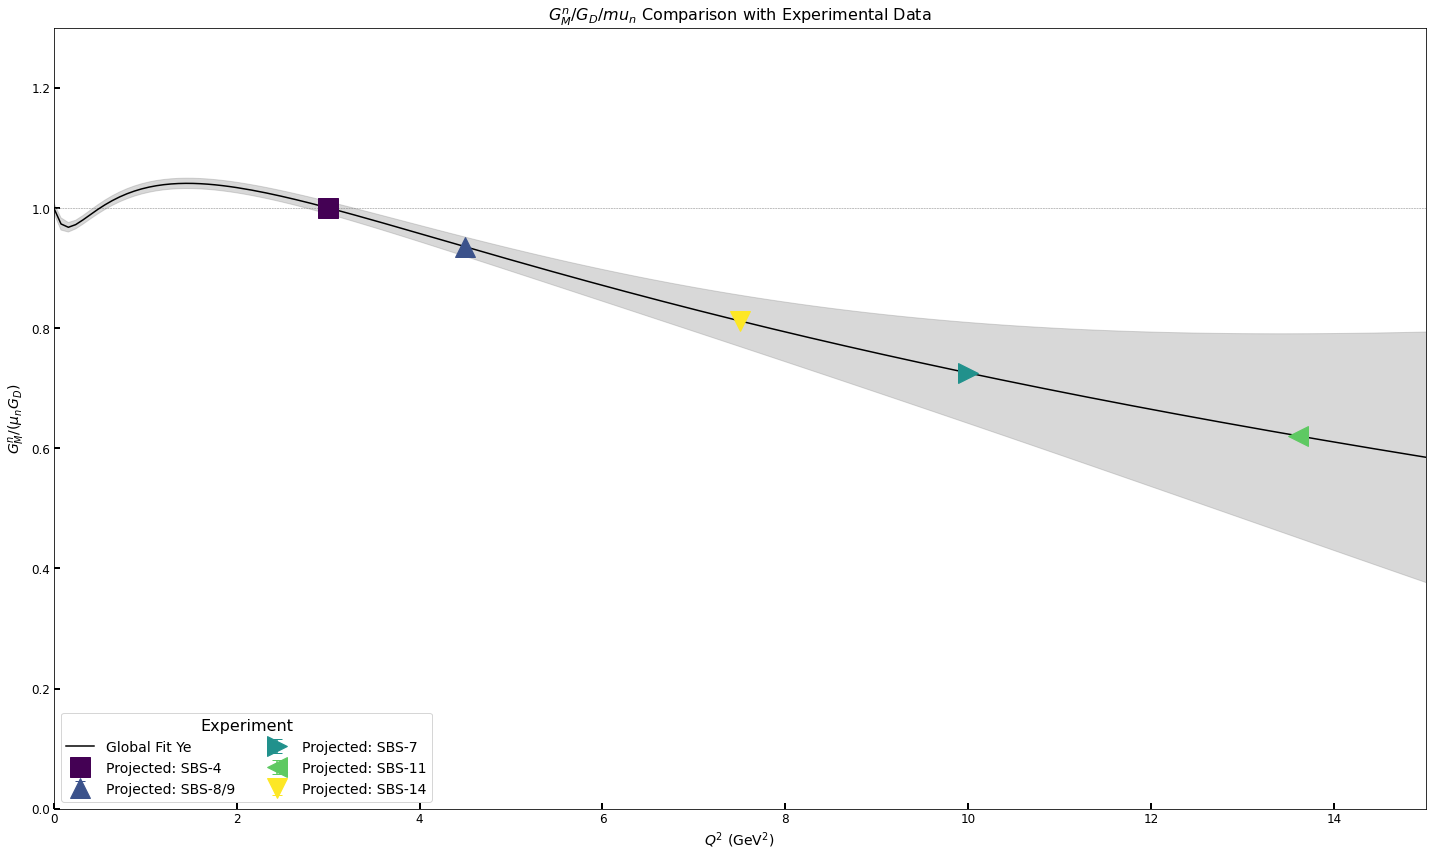

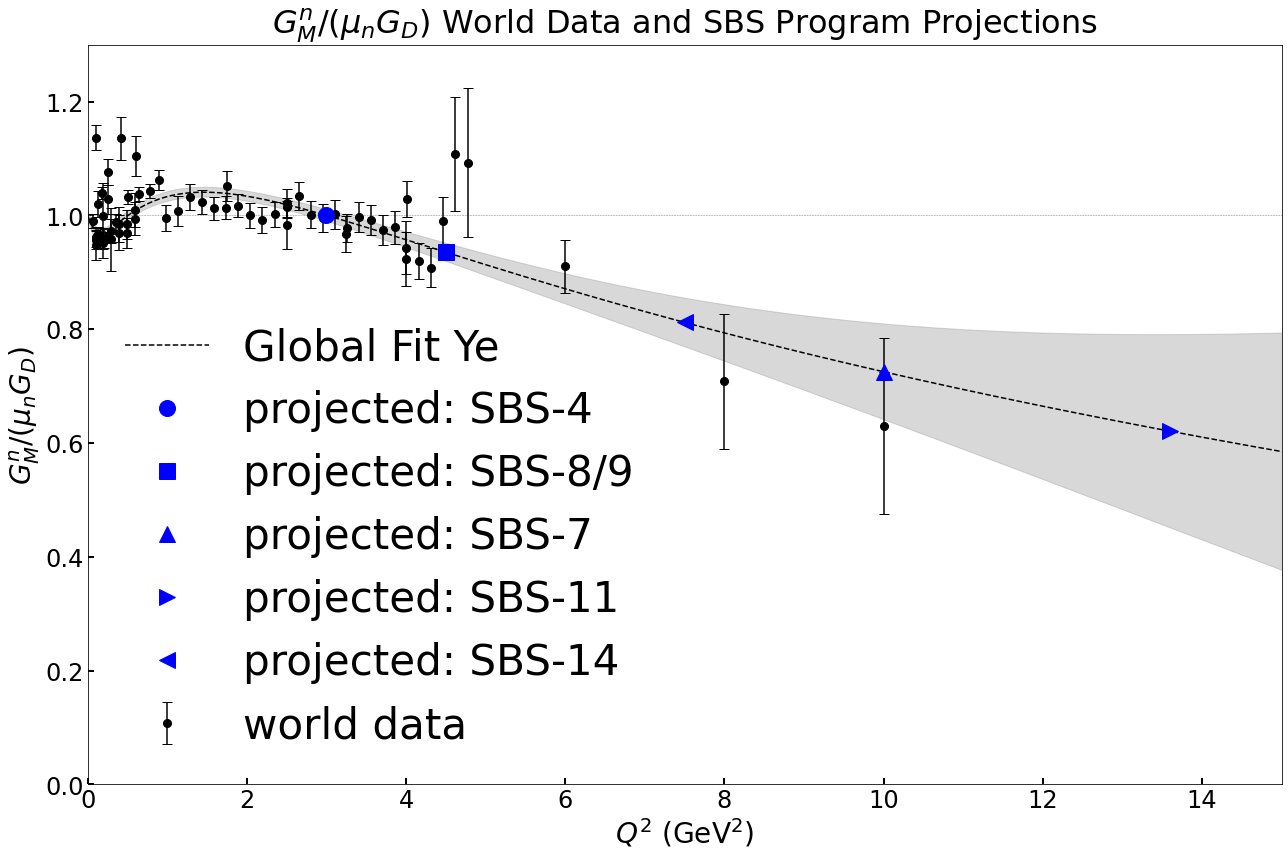

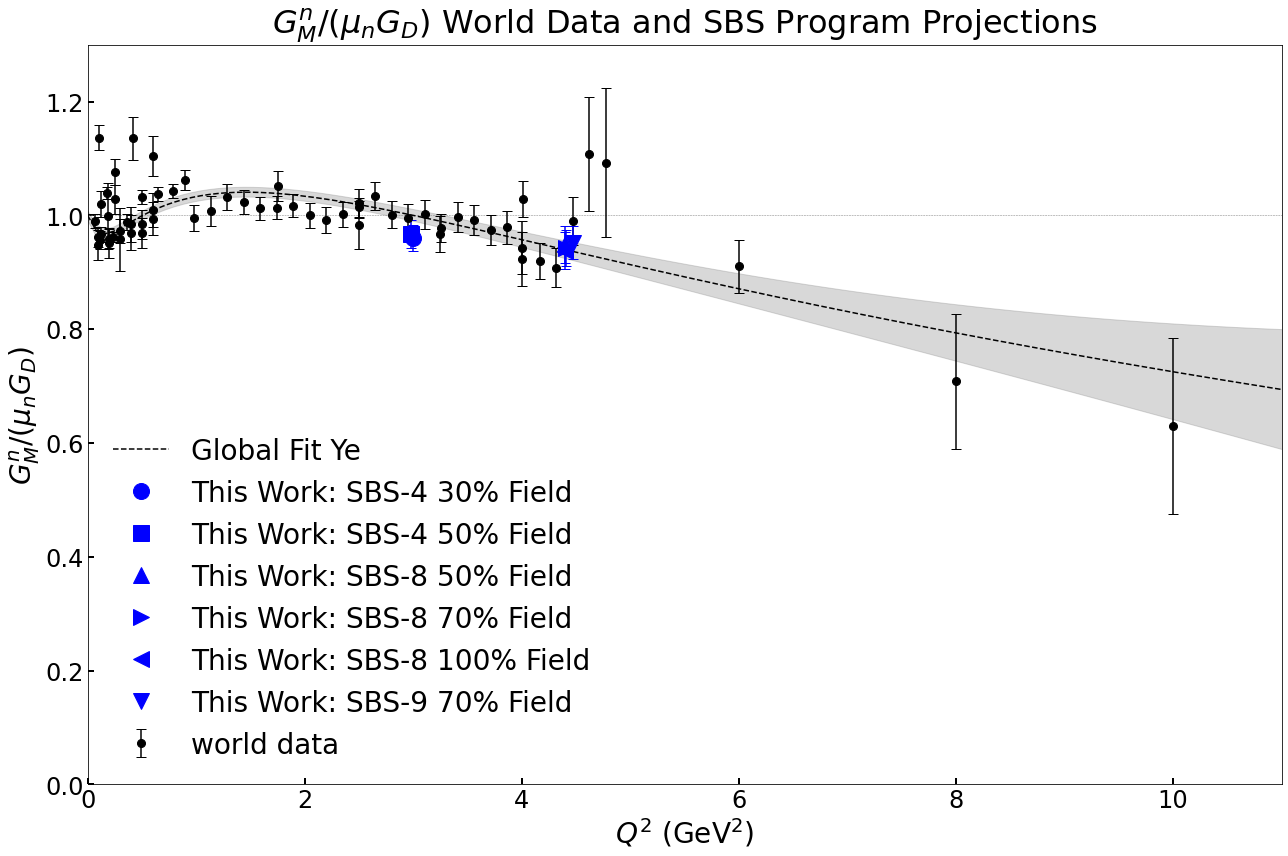

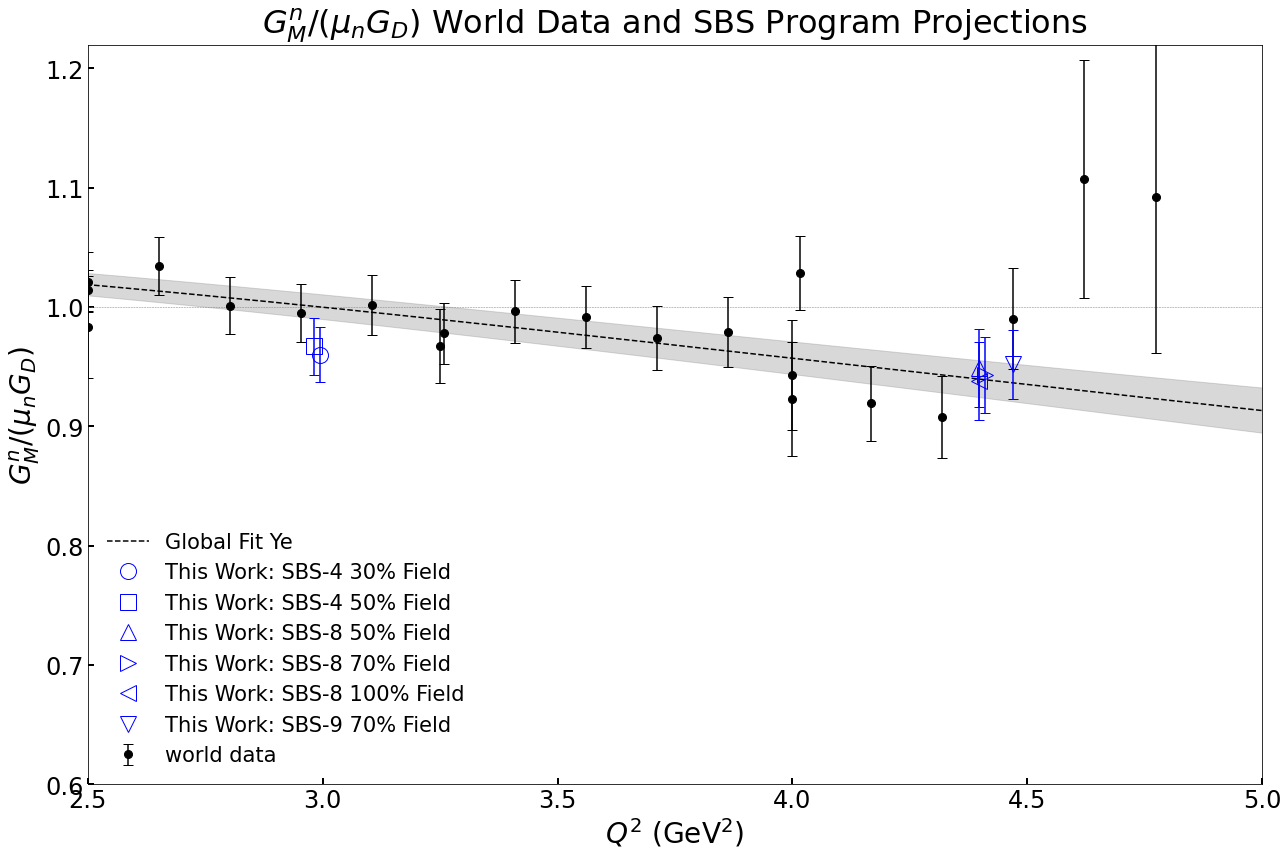

In [36]:
# Plotting individual curves
# plot_curve_with_error_bands(Q2_values, kelly_GEn_over_GD_values, kelly_GEn_upper_values, kelly_GEn_lower_values, 'Kelly GEn/GD', log_scale_x=True)
# plot_curve_with_error_bands(Q2_values, kelly_GMn_over_GD_values, kelly_GMn_upper_values, kelly_GMn_lower_values, 'Kelly GMn/GD', log_scale_x=True)
# plot_curve_with_error_bands(Q2_values, kelly_GEp_over_GD_values, kelly_GEp_upper_values, kelly_GEp_lower_values, 'Kelly GEp/GD', log_scale_x=True)
# plot_curve_with_error_bands(Q2_values, kelly_GMp_over_GD_values, kelly_GMp_upper_values, kelly_GMp_lower_values, 'Kelly GMp/GD', log_scale_x=True)
# plot_curve_with_error_bands(Q2_values, riordan_GEn_over_GD_values, riordan_GEn_upper_values, riordan_GEn_lower_values, 'Riordan GEn/GD', log_scale_x=True)
# plot_curve_with_error_bands(Q2_values, arrington07_GEp_over_GD_values, arrington07_GEp_upper_values, arrington07_GEp_lower_values, 'Arrington07 GEp/GD', log_scale_x=True)
# plot_curve_with_error_bands(Q2_values, arrington07_GMp_over_GD_values, arrington07_GMp_upper_values, arrington07_GMp_lower_values, 'Arrington07 GMp/GD', log_scale_x=True)
# plot_curve_with_error_bands(Q2_values, ye_GEn_over_GD_values, ye_GEn_upper_values, ye_GEn_lower_values, 'Ye GEn/GD', log_scale_x=True)
# plot_curve_with_error_bands(Q2_values, ye_GMn_over_GD_values, ye_GMn_upper_values, ye_GMn_lower_values, 'Ye GMn/GD', log_scale_x=True)
# plot_curve_with_error_bands(Q2_values, ye_GEp_over_GD_values, ye_GEp_upper_values, ye_GEp_lower_values, 'Ye GEp/GD', log_scale_x=True)
# plot_curve_with_error_bands(Q2_values, ye_GMp_over_GD_values, ye_GMp_upper_values, ye_GMp_lower_values, 'Ye GMp/GD', log_scale_x=True)

# # Plot GEn datasets together
# plot_curves(GEn_datasets, log_scale_x=True, title='Comparison of GEn Curves')
# Plot GEp datasets together
#plot_curves(GEp_datasets, log_scale_x=True, title='Comparison of GEp Curves')
# # Plot GMn datasets together
# plot_curves(GMn_datasets, log_scale_x=True, title='Comparison of GMn Curves')
# # Plot GMp datasets together
# plot_curves(GMp_datasets, log_scale_x=True, title='Comparison of GMp Curves')

# Plot GMp with data
#plot_gmp_with_data(GMp_datasets, GMp_data, log_scale_x=True, title='$G_M^p/G_D/mu_p$ Comparison with Experimental Data', xmax=40)
#plot_gen_with_data(GEn_datasets, correct_GEn_data_for_GD(GEn_data), log_scale_x=False, title='$G_E^n/G_D$ Comparison with Experimental Data')
#plot_gmn_with_data2(GMn_datasets, GMn_data_short, log_scale_x=False, title='$G_M^n/G_D/mu_n$ Comparison with Experimental Data')
#plot_gmn_with_data2(GMn_datasets, GMn_data_short, log_scale_x=False, title='$G_M^n/G_D/mu_n$ Comparison with Experimental Data', xmin=2.25, xmax=3.5, ymin=0.8, ymax=1.1)
#plot_gmn_with_data2(GMn_datasets, GMn_data_short, log_scale_x=False, title='$G_M^n/G_D/mu_n$ Comparison with Experimental Data', xmin=4.2, xmax=4.6, ymin=0.8, ymax=1.1)
#plot_gep_with_data2(GEp_datasets, GEp_data_short, log_scale_x=True, title='$G_E^p/G_D$ Comparison with Experimental Data')
plot_gmn_with_data2(GMn_proj_datasets, GMn_data_proj, log_scale_x=False, title='$G_M^n/G_D/mu_n$ Comparison with Experimental Data', xmax=15, msize=20)
plot_gmn_with_data3(GMn_proj_datasets, GMn_data_nodetail, log_scale_x=False, title='$G_M^n/G_D/mu_n$ Comparison with Experimental Data', xmax=15)
plot_gmn_with_data3_ext(GMn_datasets, GMn_data_nodetail_wextr, log_scale_x=False, title='$G_M^n/G_D/mu_n$ Comparison with Experimental Data', xmax=11)
plot_gmn_with_data3_extzoom(GMn_datasets, GMn_data_nodetail_wextr, log_scale_x=False, title='$G_M^n/G_D/mu_n$ Comparison with Experimental Data', xmin=2.5, xmax=5, ymin=0.6, ymax=1.22)